# Protein Complexes in Ovarian Cancer

In [30]:
import pandas as pd
import numpy as np
import scipy.stats
import re
import matplotlib.pyplot as plt
import seaborn as sns

### Import patient data as well as a list of protein complexes from CORUM (http://mips.helmholtz-muenchen.de/corum/#download 'Complete Complexes')

In [2]:
data = pd.read_csv('proteinGroups_cleaned.txt', sep='\t')

# Remove duplicate rows from the dataset
data = data.set_index('Gene_Name')
data = data.loc[~data.index.duplicated()]
complexData = pd.read_csv('allComplexes.txt', sep='\t')

### Create a workable dictionary of protein complex information

In [3]:
# Select for human complexes
complexData = complexData.loc[complexData['Organism'] == 'Human']

# Split the proteins in each complex into invdividual columns of a new df
subunitNames = complexData['subunits(Gene name)'].str.split(';', expand = True)
subunitNames.index = complexData.ComplexName

# Create a dictionary (key = complex name, value = list of proteins in complex) and remove None values
subunitNames = subunitNames.loc[~subunitNames.index.duplicated()]
subunitNames = subunitNames.transpose().to_dict('list')
for key, val in subunitNames.items():
    subunitNames[key] = [value for value in val if value != None]

### Define basic analysis and display functions

In [50]:
"""
stat_tests_ratio
-----------
All patients, single protein, tumor vs normal
T-test and levene test for difference in mean and variance, respectively

Parameters:
    prot1, prot2 = (gene) names of the two proteins to be compared (ratio of prot1 / prot2)
    
Returns:
    p-value of ttest
    
"""
def stat_tests_ratio(prot1, prot2):
    # Make sure that both proteins are in our dataset
    if not data.index.contains(prot1) or not data.index.contains(prot2): return np.nan
    
    # Create a dataframe of ratios for easy testing
    tumor_rows_list = []
    normal_rows_list = []
    for patient in data.columns:
        sample_type = 'Tumor'
        if '_NM' in patient: sample_type = 'Normal'
            
        ratio = data.at[prot1, patient] / data.at[prot2, patient]
        row_dict = {'Ratio': ratio, 'Sample_Type': sample_type}
        
        if sample_type == 'Tumor':
            tumor_rows_list.append(row_dict)
        else:
            normal_rows_list.append(row_dict)
            
    tumor_ratio_df = pd.DataFrame(tumor_rows_list)
    normal_ratio_df = pd.DataFrame(normal_rows_list)
    
    return scipy.stats.ttest_ind(tumor_ratio_df['Ratio'], normal_ratio_df['Ratio'])[1], scipy.stats.levene(tumor_ratio_df['Ratio'], normal_ratio_df['Ratio'])[1]

"""
test_complex
------------
Perform statistical tests on every combination of proteins in a given complex, plotting significant values

"""

"""
find_ratios
-----------
All patients, tumor vs normal

Parameters:
    protein_list = list of proteins in the complex

Returns:
    A dataframe with four columns: Patient_ID, Protein, Ratio, Sample_Type (Tumor or Normal)

"""
def find_ratios(protein_list):

    rows_list = []
    num_tumor = 0 
    num_normal = 0
    
    # Find the ratios for each protein in the complex for each patient
    for patient in data.columns:
        row_dict = {}
        total_expression = 0
        
        # Determine the sample type
        sample_type = 'Tumor'
        if '_NM' in patient: sample_type = 'Normal'
            
        # Find the total expression level for the whole complex  
        for protein in protein_list:
            if not data.index.contains(protein): continue
            total_expression += data.at[protein, patient]

        # Find the ratio of each individual protein to the total for the complex
        if total_expression == 0:
            continue
        else:
            if sample_type == 'Normal': 
                num_normal += 1
            else:
                num_tumor += 1
            for protein in protein_list:
                if not data.index.contains(protein): continue
                ratio_value = data.at[protein, patient] / total_expression
                row_dict = {'Patient_ID': patient, 'Protein': protein, 'Ratio': ratio_value, 'Sample_Type': sample_type}
                rows_list.append(row_dict)
    
    return pd.DataFrame(rows_list), num_normal, num_tumor

"""
plot_ratios
-----------
Create a seaborn plot for the ratios in a dataframe

Parameters:
    plot_data = dataframe with ratio values (output of find_ratios)
    complex_name = name of the complex
    
Returns:
    Displays a plot of the data
    
"""
def plot_ratios(plot_data):
    
    a4_dims = (10, 10)
    fig, ax = plt.subplots(figsize=a4_dims)

    #Create the plot
    boxplt = sns.boxplot(data=plot_data, x='Protein', y='Ratio', hue='Sample_Type', showfliers=False)
    boxplt = sns.stripplot(data=plot_data, x='Protein', y='Ratio', hue='Sample_Type', dodge=True, jitter=True, color='.3')

    #Add styling
    boxplt.set_xlabel('')
    boxplt.set_ylabel('Protein Expression Ratio', fontsize='20')
    boxplt.tick_params(labelsize='15')
    
    #Adjust legend
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[0:2], ['Tumor', 'Normal'], title='Sample Type', fontsize='12', frameon=False)
    boxplt.get_legend().get_title().set_fontsize('13')
    boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


In [51]:
stat_tests_ratio('SLC25A5', 'PHB')

(0.03778427196203222, 0.24167443557882615)

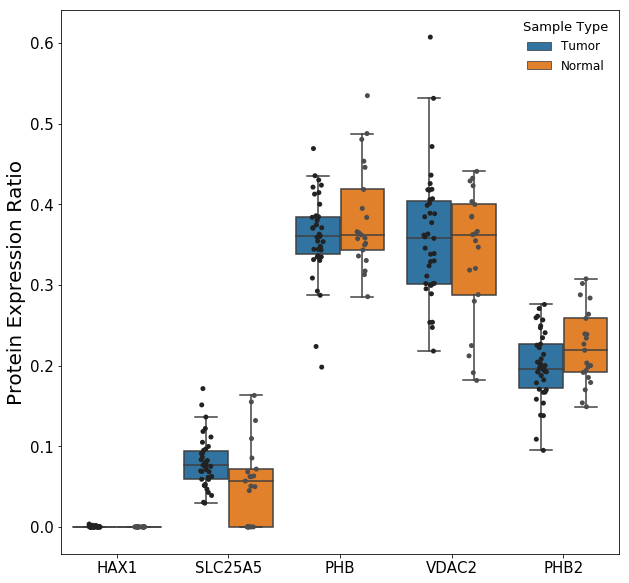

In [28]:
plot_ratios(find_ratios(['HAX1', 'SLC25A5', 'PHB', 'VDAC2', 'PHB2'])[0])

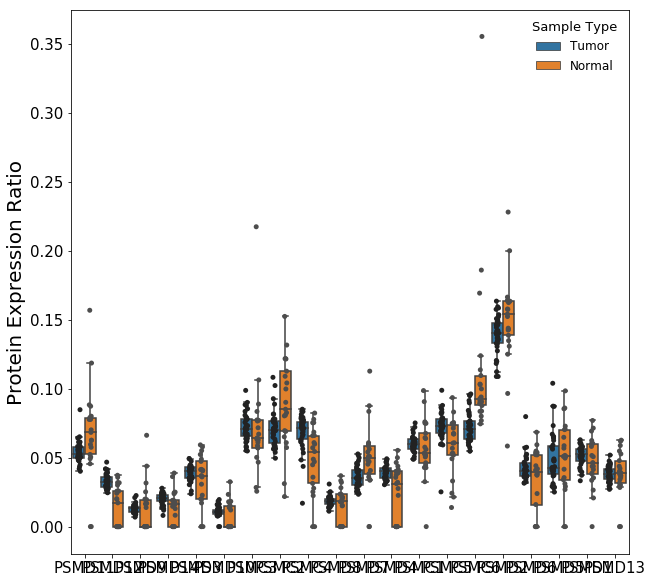

In [27]:
plot_ratios(find_ratios(['PSMD11', 'PSMD12', 'PSMD9', 'PSMD14', 'PSMD3', 'PSMD10', 'PSMC3', 'PSMC2', 'PSMC4', 'PSMD8', 'PSMD7', 'PSMD4', 'PSMC1', 'PSMC5', 'PSMC6', 'PSMD2', 'PSMD6', 'PSMD5', 'PSMD1', 'PSMD13'])[0])

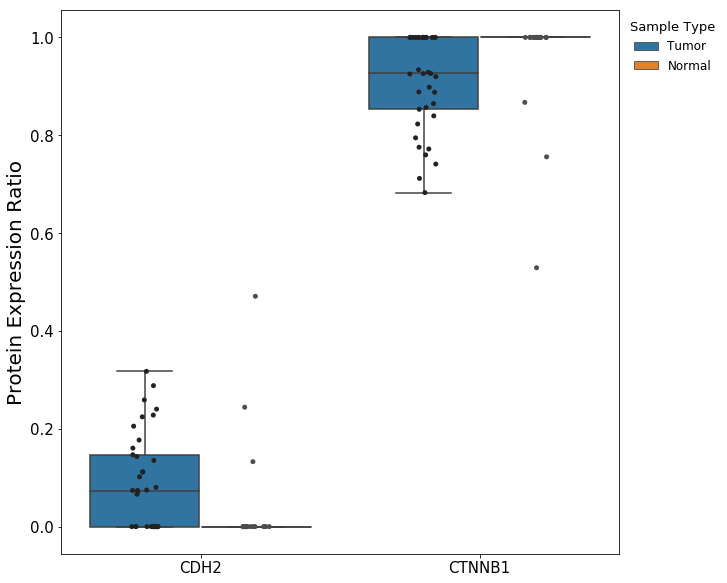

In [29]:
plot_ratios(find_ratios(['DLL1', 'CDH2', 'CTNNB1'])[0])

In [24]:
for key, value in subunitNames.items():
    print(value)
    df, num_normal, num_tumor = find_ratios(value)
    print("Number of normal samples: " + str(num_normal))
    print("Number of tumor samples: " + str(num_tumor))
    print(df)

['BCL6', 'HDAC4']
Number of normal samples: 0
Number of tumor samples: 0
Empty DataFrame
Columns: []
Index: []
['BCL6', 'HDAC5']
Number of normal samples: 0
Number of tumor samples: 0
Empty DataFrame
Columns: []
Index: []
['BCL6', 'HDAC7']
Number of normal samples: 0
Number of tumor samples: 5
  Patient_ID Protein  Ratio Sample_Type
0    01OV039   HDAC7    1.0       Tumor
1    02OV006   HDAC7    1.0       Tumor
2    04OV004   HDAC7    1.0       Tumor
3    04OV027   HDAC7    1.0       Tumor
4    14OV011   HDAC7    1.0       Tumor
['EP300', 'CREBBP', 'KAT2B', 'NCOA3']
Number of normal samples: 0
Number of tumor samples: 2
  Patient_ID Protein  Ratio Sample_Type
0    04OV004  CREBBP    1.0       Tumor
1    04OV017  CREBBP    1.0       Tumor
['SMC2', 'NCAPH', 'NCAPD2', 'NCAPG', 'SMC4']
Number of normal samples: 2
Number of tumor samples: 29
     Patient_ID Protein     Ratio Sample_Type
0       01OV017    SMC2  0.313654       Tumor
1       01OV017   NCAPH  0.000000       Tumor
2       01OV0

[200 rows x 4 columns]
['PSEN1', 'NCSTN', 'APH1A', 'PSENEN']
Number of normal samples: 2
Number of tumor samples: 29
    Patient_ID Protein     Ratio Sample_Type
0      01OV007   PSEN1  0.000000       Tumor
1      01OV007   NCSTN  1.000000       Tumor
2      01OV007   APH1A  0.000000       Tumor
3      01OV017   PSEN1  0.000000       Tumor
4      01OV017   NCSTN  1.000000       Tumor
5      01OV017   APH1A  0.000000       Tumor
6   01OV019_NM   PSEN1  0.000000      Normal
7   01OV019_NM   NCSTN  1.000000      Normal
8   01OV019_NM   APH1A  0.000000      Normal
9      01OV023   PSEN1  0.000000       Tumor
10     01OV023   NCSTN  1.000000       Tumor
11     01OV023   APH1A  0.000000       Tumor
12     01OV029   PSEN1  0.000000       Tumor
13     01OV029   NCSTN  1.000000       Tumor
14     01OV029   APH1A  0.000000       Tumor
15     01OV039   PSEN1  0.308222       Tumor
16     01OV039   NCSTN  0.691778       Tumor
17     01OV039   APH1A  0.000000       Tumor
18     02OV005   PSEN1  0.00

[224 rows x 4 columns]
['MED14', 'MED24', 'THRA', 'MED1', 'MED12', 'MED17', 'THRAP3', 'MED16']
Number of normal samples: 13
Number of tumor samples: 37
     Patient_ID Protein     Ratio Sample_Type
0       01OV007   MED14  0.000000       Tumor
1       01OV007   MED24  0.000000       Tumor
2       01OV007    MED1  0.000000       Tumor
3       01OV007   MED12  0.000000       Tumor
4       01OV007  THRAP3  1.000000       Tumor
5    01OV010_NM   MED14  0.000000      Normal
6    01OV010_NM   MED24  0.000000      Normal
7    01OV010_NM    MED1  0.000000      Normal
8    01OV010_NM   MED12  0.000000      Normal
9    01OV010_NM  THRAP3  1.000000      Normal
10   01OV013_NM   MED14  0.000000      Normal
11   01OV013_NM   MED24  0.000000      Normal
12   01OV013_NM    MED1  0.000000      Normal
13   01OV013_NM   MED12  0.000000      Normal
14   01OV013_NM  THRAP3  1.000000      Normal
15      01OV017   MED14  0.000000       Tumor
16      01OV017   MED24  0.000000       Tumor
17      01OV017    M

Number of normal samples: 19
Number of tumor samples: 38
     Patient_ID  Protein     Ratio Sample_Type
0       01OV007  SMARCA1  0.000000       Tumor
1       01OV007    RBBP4  0.737488       Tumor
2       01OV007     BPTF  0.000000       Tumor
3       01OV007    RBBP7  0.262512       Tumor
4    01OV008_NM  SMARCA1  0.000000      Normal
5    01OV008_NM    RBBP4  0.547345      Normal
6    01OV008_NM     BPTF  0.000000      Normal
7    01OV008_NM    RBBP7  0.452655      Normal
8    01OV010_NM  SMARCA1  0.000000      Normal
9    01OV010_NM    RBBP4  0.249756      Normal
10   01OV010_NM     BPTF  0.000000      Normal
11   01OV010_NM    RBBP7  0.750244      Normal
12   01OV013_NM  SMARCA1  0.000000      Normal
13   01OV013_NM    RBBP4  1.000000      Normal
14   01OV013_NM     BPTF  0.000000      Normal
15   01OV013_NM    RBBP7  0.000000      Normal
16      01OV017  SMARCA1  0.131964       Tumor
17      01OV017    RBBP4  0.636505       Tumor
18      01OV017     BPTF  0.000000       Tumor
19 

[212 rows x 4 columns]
['APBB1', 'APP', 'LRP1']
Number of normal samples: 20
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007   APBB1  0.000000       Tumor
1       01OV007     APP  0.012567       Tumor
2       01OV007    LRP1  0.987433       Tumor
3    01OV007_NM   APBB1  0.000000      Normal
4    01OV007_NM     APP  0.000000      Normal
5    01OV007_NM    LRP1  1.000000      Normal
6    01OV008_NM   APBB1  0.000000      Normal
7    01OV008_NM     APP  0.000000      Normal
8    01OV008_NM    LRP1  1.000000      Normal
9    01OV013_NM   APBB1  0.000000      Normal
10   01OV013_NM     APP  0.000000      Normal
11   01OV013_NM    LRP1  1.000000      Normal
12      01OV017   APBB1  0.000000       Tumor
13      01OV017     APP  0.097287       Tumor
14      01OV017    LRP1  0.902713       Tumor
15   01OV017_NM   APBB1  0.000000      Normal
16   01OV017_NM     APP  0.000000      Normal
17   01OV017_NM    LRP1  1.000000      Normal
18      01OV018   APB

Number of normal samples: 4
Number of tumor samples: 38
    Patient_ID  Protein     Ratio Sample_Type
0      01OV007   PPP1CA  1.000000       Tumor
1      01OV007  PPP1R10  0.000000       Tumor
2      01OV017   PPP1CA  1.000000       Tumor
3      01OV017  PPP1R10  0.000000       Tumor
4   01OV017_NM   PPP1CA  1.000000      Normal
5   01OV017_NM  PPP1R10  0.000000      Normal
6      01OV018   PPP1CA  1.000000       Tumor
7      01OV018  PPP1R10  0.000000       Tumor
8   01OV019_NM   PPP1CA  1.000000      Normal
9   01OV019_NM  PPP1R10  0.000000      Normal
10     01OV023   PPP1CA  1.000000       Tumor
11     01OV023  PPP1R10  0.000000       Tumor
12     01OV026   PPP1CA  1.000000       Tumor
13     01OV026  PPP1R10  0.000000       Tumor
14     01OV029   PPP1CA  1.000000       Tumor
15     01OV029  PPP1R10  0.000000       Tumor
16     01OV030   PPP1CA  1.000000       Tumor
17     01OV030  PPP1R10  0.000000       Tumor
18     01OV039   PPP1CA  1.000000       Tumor
19     01OV039  PPP1R10 

Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007   PSMA7  0.136707       Tumor
1       01OV007   PSMB1  0.098229       Tumor
2       01OV007   PSMA1  0.084575       Tumor
3       01OV007   PSMA2  0.070730       Tumor
4       01OV007   PSMA3  0.037753       Tumor
5       01OV007   PSMA4  0.086011       Tumor
6       01OV007   PSMA5  0.128927       Tumor
7       01OV007   PSMB4  0.049975       Tumor
8       01OV007   PSMB6  0.011995       Tumor
9       01OV007   PSMB5  0.009957       Tumor
10      01OV007   PSMB3  0.032538       Tumor
11      01OV007   PSMB2  0.078157       Tumor
12      01OV007   PSMA6  0.138892       Tumor
13      01OV007   PSME3  0.011045       Tumor
14      01OV007   PSMB7  0.024510       Tumor
15   01OV007_NM   PSMA7  0.122497      Normal
16   01OV007_NM   PSMB1  0.000000      Normal
17   01OV007_NM   PSMA1  0.065760      Normal
18   01OV007_NM   PSMA2  0.080198      Normal
19   01OV007_NM   PSMA3

Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007    RBX1  0.000000       Tumor
1       01OV007   CUL4A  0.018545       Tumor
2       01OV007   CAND1  0.981455       Tumor
3    01OV007_NM    RBX1  0.000000      Normal
4    01OV007_NM   CUL4A  0.000000      Normal
5    01OV007_NM   CAND1  1.000000      Normal
6    01OV008_NM    RBX1  0.000000      Normal
7    01OV008_NM   CUL4A  0.000000      Normal
8    01OV008_NM   CAND1  1.000000      Normal
9    01OV010_NM    RBX1  0.000000      Normal
10   01OV010_NM   CUL4A  0.327488      Normal
11   01OV010_NM   CAND1  0.672512      Normal
12   01OV013_NM    RBX1  0.000000      Normal
13   01OV013_NM   CUL4A  0.000000      Normal
14   01OV013_NM   CAND1  1.000000      Normal
15      01OV017    RBX1  0.000000       Tumor
16      01OV017   CUL4A  0.074264       Tumor
17      01OV017   CAND1  0.925736       Tumor
18   01OV017_NM    RBX1  0.000000      Normal
19   01OV017_NM   CUL4A

[232 rows x 4 columns]
['RAD51C', 'XRCC3']
Number of normal samples: 0
Number of tumor samples: 0
Empty DataFrame
Columns: []
Index: []
['MND1', 'PSMC3IP']
Number of normal samples: 0
Number of tumor samples: 0
Empty DataFrame
Columns: []
Index: []
['RAD51B', 'RAD51C']
Number of normal samples: 0
Number of tumor samples: 0
Empty DataFrame
Columns: []
Index: []
['RAD51B', 'RAD51C', 'XRCC3', 'XRCC2', 'RAD51D']
Number of normal samples: 0
Number of tumor samples: 0
Empty DataFrame
Columns: []
Index: []
['XRCC2', 'RAD51D']
Number of normal samples: 0
Number of tumor samples: 0
Empty DataFrame
Columns: []
Index: []
['ATR', 'ATRIP']
Number of normal samples: 0
Number of tumor samples: 0
Empty DataFrame
Columns: []
Index: []
['RAD17', 'RFC4', 'RFC2', 'RFC5', 'RFC3']
Number of normal samples: 2
Number of tumor samples: 34
     Patient_ID Protein     Ratio Sample_Type
0       01OV007    RFC4  0.000000       Tumor
1       01OV007    RFC2  0.249749       Tumor
2       01OV007    RFC5  0.444105   

[204 rows x 4 columns]
['MLH1', 'MSH2', 'PMS2']
Number of normal samples: 4
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007    MLH1  0.000000       Tumor
1       01OV007    MSH2  1.000000       Tumor
2       01OV007    PMS2  0.000000       Tumor
3       01OV017    MLH1  0.000000       Tumor
4       01OV017    MSH2  1.000000       Tumor
5       01OV017    PMS2  0.000000       Tumor
6       01OV018    MLH1  0.000000       Tumor
7       01OV018    MSH2  1.000000       Tumor
8       01OV018    PMS2  0.000000       Tumor
9    01OV019_NM    MLH1  0.000000      Normal
10   01OV019_NM    MSH2  1.000000      Normal
11   01OV019_NM    PMS2  0.000000      Normal
12      01OV023    MLH1  0.000000       Tumor
13      01OV023    MSH2  1.000000       Tumor
14      01OV023    PMS2  0.000000       Tumor
15   01OV023_NM    MLH1  0.000000      Normal
16   01OV023_NM    MSH2  1.000000      Normal
17   01OV023_NM    PMS2  0.000000      Normal
18      01OV026    MLH

Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007   RPLP1  0.003669       Tumor
1       01OV007   RPLP2  0.043409       Tumor
2       01OV007   RPLP0  0.031775       Tumor
3       01OV007   RPS17  0.010814       Tumor
4       01OV007    RPSA  0.043042       Tumor
5       01OV007    RPS2  0.015284       Tumor
6       01OV007  RPL35A  0.000000       Tumor
7       01OV007    RPL7  0.036821       Tumor
8       01OV007   RPL17  0.010536       Tumor
9       01OV007  RPS4Y1  0.022364       Tumor
10      01OV007    RPS3  0.028504       Tumor
11      01OV007   RPS12  0.033486       Tumor
12      01OV007   RPL13  0.012584       Tumor
13      01OV007   RPL10  0.010430       Tumor
14      01OV007   RPL12  0.022994       Tumor
15      01OV007   RPL22  0.016325       Tumor
16      01OV007    RPL4  0.022824       Tumor
17      01OV007   RPS19  0.019623       Tumor
18      01OV007    RPL3  0.014049       Tumor
19      01OV007  RPL13A

Number of normal samples: 19
Number of tumor samples: 38
     Patient_ID  Protein     Ratio Sample_Type
0       01OV007   MRPS14  0.000000       Tumor
1       01OV007    MRPL3  0.000000       Tumor
2       01OV007   MRPL19  0.000000       Tumor
3       01OV007     DAP3  0.037397       Tumor
4       01OV007   MRPL12  0.167981       Tumor
5       01OV007   MRPS22  0.078174       Tumor
6       01OV007   MRPS25  0.000000       Tumor
7       01OV007   MRPS35  0.030903       Tumor
8       01OV007    MRPS5  0.000000       Tumor
9       01OV007   MRPS36  0.070333       Tumor
10      01OV007   MRPS11  0.000000       Tumor
11      01OV007   MRPS21  0.000000       Tumor
12      01OV007   MRPS34  0.066097       Tumor
13      01OV007    MRPS6  0.000000       Tumor
14      01OV007    MRPS9  0.000000       Tumor
15      01OV007    LACTB  0.105083       Tumor
16      01OV007   MRPL28  0.000000       Tumor
17      01OV007   MRPL49  0.000000       Tumor
18      01OV007   MRPL23  0.000000       Tumor
19 

Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID   Protein     Ratio Sample_Type
0       01OV007   IGF2BP3  0.000000       Tumor
1       01OV007     DDX3X  0.014378       Tumor
2       01OV007    TCERG1  0.006122       Tumor
3       01OV007    U2SURP  0.004319       Tumor
4       01OV007     PPM1G  0.001550       Tumor
5       01OV007     DHX15  0.009619       Tumor
6       01OV007     PRPF4  0.001038       Tumor
7       01OV007     SART1  0.143697       Tumor
8       01OV007     PRPF3  0.000789       Tumor
9       01OV007      PPIH  0.001327       Tumor
10      01OV007     PLRG1  0.000000       Tumor
11      01OV007    ZNF207  0.003257       Tumor
12      01OV007   HTATSF1  0.002290       Tumor
13      01OV007    NUDT21  0.005970       Tumor
14      01OV007     DHX16  0.002723       Tumor
15      01OV007       AQR  0.000693       Tumor
16      01OV007     CDC40  0.000000       Tumor
17      01OV007   PRPF40A  0.001847       Tumor
18      01OV007     SF3B1  0.02

[66 rows x 4 columns]
['SKP1', 'CUL1', 'FBXW2']
Number of normal samples: 20
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007    SKP1  0.758871       Tumor
1       01OV007    CUL1  0.241129       Tumor
2    01OV007_NM    SKP1  1.000000      Normal
3    01OV007_NM    CUL1  0.000000      Normal
4    01OV008_NM    SKP1  1.000000      Normal
5    01OV008_NM    CUL1  0.000000      Normal
6    01OV010_NM    SKP1  0.621308      Normal
7    01OV010_NM    CUL1  0.378692      Normal
8    01OV013_NM    SKP1  1.000000      Normal
9    01OV013_NM    CUL1  0.000000      Normal
10      01OV017    SKP1  0.886652       Tumor
11      01OV017    CUL1  0.113348       Tumor
12   01OV017_NM    SKP1  1.000000      Normal
13   01OV017_NM    CUL1  0.000000      Normal
14      01OV018    SKP1  0.876133       Tumor
15      01OV018    CUL1  0.123867       Tumor
16   01OV019_NM    SKP1  1.000000      Normal
17   01OV019_NM    CUL1  0.000000      Normal
18      01OV023    SK

Number of normal samples: 8
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007    RFC4  0.000000       Tumor
1       01OV007    RFC2  0.212051       Tumor
2       01OV007    RFC1  0.000000       Tumor
3       01OV007    MLH1  0.000000       Tumor
4       01OV007    MSH2  0.491396       Tumor
5       01OV007    MSH6  0.296553       Tumor
6       01OV017    RFC4  0.104932       Tumor
7       01OV017    RFC2  0.072413       Tumor
8       01OV017    RFC1  0.054236       Tumor
9       01OV017    MLH1  0.000000       Tumor
10      01OV017    MSH2  0.388390       Tumor
11      01OV017    MSH6  0.380030       Tumor
12   01OV017_NM    RFC4  0.000000      Normal
13   01OV017_NM    RFC2  0.000000      Normal
14   01OV017_NM    RFC1  0.000000      Normal
15   01OV017_NM    MLH1  0.000000      Normal
16   01OV017_NM    MSH2  0.000000      Normal
17   01OV017_NM    MSH6  1.000000      Normal
18      01OV018    RFC4  0.000000       Tumor
19      01OV018    RFC2 

58     17OV026    P4HB    1.0       Tumor
['SUPT3H', 'TADA3', 'TAF5L', 'SUPT7L', 'TAF10', 'SF3B3', 'TAF12', 'TAF9', 'KAT2A', 'TADA1', 'TRRAP', 'TAF6L']
Number of normal samples: 15
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007   TAF10  0.000000       Tumor
1       01OV007   SF3B3  1.000000       Tumor
2       01OV007    TAF9  0.000000       Tumor
3       01OV007   TRRAP  0.000000       Tumor
4    01OV013_NM   TAF10  0.000000      Normal
5    01OV013_NM   SF3B3  1.000000      Normal
6    01OV013_NM    TAF9  0.000000      Normal
7    01OV013_NM   TRRAP  0.000000      Normal
8       01OV017   TAF10  0.034777       Tumor
9       01OV017   SF3B3  0.965223       Tumor
10      01OV017    TAF9  0.000000       Tumor
11      01OV017   TRRAP  0.000000       Tumor
12   01OV017_NM   TAF10  0.000000      Normal
13   01OV017_NM   SF3B3  0.809208      Normal
14   01OV017_NM    TAF9  0.000000      Normal
15   01OV017_NM   TRRAP  0.190792      Normal
16      0

     Patient_ID  Protein     Ratio Sample_Type
0       01OV007   ACTL6A  0.103797       Tumor
1       01OV007  MORF4L2  0.000000       Tumor
2       01OV007     BRD8  0.000000       Tumor
3       01OV007    DMAP1  0.000000       Tumor
4       01OV007    MRGBP  0.006865       Tumor
5       01OV007  MORF4L1  0.000000       Tumor
6       01OV007   RUVBL2  0.415570       Tumor
7       01OV007   RUVBL1  0.473768       Tumor
8       01OV007    TRRAP  0.000000       Tumor
9    01OV007_NM   ACTL6A  0.000000      Normal
10   01OV007_NM  MORF4L2  0.000000      Normal
11   01OV007_NM     BRD8  0.000000      Normal
12   01OV007_NM    DMAP1  0.000000      Normal
13   01OV007_NM    MRGBP  0.000000      Normal
14   01OV007_NM  MORF4L1  0.000000      Normal
15   01OV007_NM   RUVBL2  0.000000      Normal
16   01OV007_NM   RUVBL1  1.000000      Normal
17   01OV007_NM    TRRAP  0.000000      Normal
18   01OV008_NM   ACTL6A  0.173116      Normal
19   01OV008_NM  MORF4L2  0.000000      Normal
20   01OV008_

Number of normal samples: 9
Number of tumor samples: 38
    Patient_ID Protein     Ratio Sample_Type
0      01OV007    TP53  0.000000       Tumor
1      01OV007    FHL2  1.000000       Tumor
2      01OV017    TP53  0.000000       Tumor
3      01OV017    FHL2  1.000000       Tumor
4      01OV018    TP53  0.164448       Tumor
5      01OV018    FHL2  0.835552       Tumor
6   01OV019_NM    TP53  0.000000      Normal
7   01OV019_NM    FHL2  1.000000      Normal
8      01OV023    TP53  0.018421       Tumor
9      01OV023    FHL2  0.981579       Tumor
10  01OV023_NM    TP53  0.000000      Normal
11  01OV023_NM    FHL2  1.000000      Normal
12     01OV026    TP53  0.000000       Tumor
13     01OV026    FHL2  1.000000       Tumor
14     01OV029    TP53  0.000000       Tumor
15     01OV029    FHL2  1.000000       Tumor
16  01OV029_NM    TP53  0.000000      Normal
17  01OV029_NM    FHL2  1.000000      Normal
18     01OV030    TP53  0.000000       Tumor
19     01OV030    FHL2  1.000000       Tumor

Number of normal samples: 3
Number of tumor samples: 35
    Patient_ID Protein     Ratio Sample_Type
0      01OV017   KDM1A  0.787740       Tumor
1      01OV017   RCOR1  0.212260       Tumor
2      01OV018   KDM1A  0.732863       Tumor
3      01OV018   RCOR1  0.267137       Tumor
4   01OV019_NM   KDM1A  1.000000      Normal
5   01OV019_NM   RCOR1  0.000000      Normal
6      01OV023   KDM1A  1.000000       Tumor
7      01OV023   RCOR1  0.000000       Tumor
8      01OV026   KDM1A  1.000000       Tumor
9      01OV026   RCOR1  0.000000       Tumor
10     01OV029   KDM1A  0.731234       Tumor
11     01OV029   RCOR1  0.268766       Tumor
12     01OV030   KDM1A  0.753231       Tumor
13     01OV030   RCOR1  0.246769       Tumor
14     01OV039   KDM1A  0.697192       Tumor
15     01OV039   RCOR1  0.302808       Tumor
16     01OV041   KDM1A  0.808693       Tumor
17     01OV041   RCOR1  0.191307       Tumor
18  02OV001_NM   KDM1A  1.000000      Normal
19  02OV001_NM   RCOR1  0.000000      Normal

[120 rows x 4 columns]
['TMEM50A', 'RANBP9']
Number of normal samples: 3
Number of tumor samples: 4
   Patient_ID Protein  Ratio Sample_Type
0  01OV007_NM  RANBP9    1.0      Normal
1  01OV013_NM  RANBP9    1.0      Normal
2  01OV023_NM  RANBP9    1.0      Normal
3     02OV023  RANBP9    1.0       Tumor
4     02OV032  RANBP9    1.0       Tumor
5     04OV008  RANBP9    1.0       Tumor
6     15OV001  RANBP9    1.0       Tumor
['CBX4', 'ZEB2', 'KDM1A', 'ZNF217', 'ZEB1', 'CTBP2', 'CTBP1', 'HDAC1', 'ZNF516', 'RREB1', 'HDAC2', 'LCOR', 'EHMT2', 'EHMT1', 'RCOR3', 'RCOR1', 'CDYL']
Number of normal samples: 17
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007   KDM1A  0.000000       Tumor
1       01OV007   CTBP2  0.167752       Tumor
2       01OV007   CTBP1  0.351103       Tumor
3       01OV007   HDAC1  0.340982       Tumor
4       01OV007  ZNF516  0.000000       Tumor
5       01OV007   RREB1  0.000000       Tumor
6       01OV007   HDAC2  0.140163       Tu

Empty DataFrame
Columns: []
Index: []
['ADRB2', 'KCNMA1']
Number of normal samples: 0
Number of tumor samples: 0
Empty DataFrame
Columns: []
Index: []
['GINS1', 'GINS4', 'GINS3', 'GINS2']
Number of normal samples: 0
Number of tumor samples: 1
  Patient_ID Protein     Ratio Sample_Type
0    17OV026   GINS3  0.294419       Tumor
1    17OV026   GINS2  0.705581       Tumor
['RANBP1', 'ENTPD1']
Number of normal samples: 13
Number of tumor samples: 31
    Patient_ID Protein     Ratio Sample_Type
0      01OV007  RANBP1  0.932053       Tumor
1      01OV007  ENTPD1  0.067947       Tumor
2   01OV013_NM  RANBP1  1.000000      Normal
3   01OV013_NM  ENTPD1  0.000000      Normal
4      01OV017  RANBP1  1.000000       Tumor
5      01OV017  ENTPD1  0.000000       Tumor
6   01OV017_NM  RANBP1  0.560226      Normal
7   01OV017_NM  ENTPD1  0.439774      Normal
8      01OV018  RANBP1  0.754797       Tumor
9      01OV018  ENTPD1  0.245203       Tumor
10  01OV019_NM  RANBP1  0.531669      Normal
11  01OV01

Number of normal samples: 19
Number of tumor samples: 38
     Patient_ID  Protein     Ratio Sample_Type
0       01OV007   ARID1A  0.044805       Tumor
1       01OV007    PRMT5  0.071600       Tumor
2       01OV007   ACTL6A  0.096302       Tumor
3       01OV007  SMARCA4  0.072339       Tumor
4       01OV007    RBBP4  0.336245       Tumor
5       01OV007  SMARCB1  0.023333       Tumor
6       01OV007  SMARCD3  0.017195       Tumor
7       01OV007  SMARCC2  0.169199       Tumor
8       01OV007    HDAC2  0.062527       Tumor
9       01OV007  SMARCC1  0.024089       Tumor
10      01OV007  SMARCD2  0.017195       Tumor
11      01OV007  SMARCE1  0.038574       Tumor
12      01OV007    SIN3A  0.026596       Tumor
13   01OV008_NM   ARID1A  0.000000      Normal
14   01OV008_NM    PRMT5  0.000000      Normal
15   01OV008_NM   ACTL6A  0.391884      Normal
16   01OV008_NM  SMARCA4  0.000000      Normal
17   01OV008_NM    RBBP4  0.289856      Normal
18   01OV008_NM  SMARCB1  0.000000      Normal
19 

[104 rows x 4 columns]
['SNAP23', 'VAMP2', 'STX4']
Number of normal samples: 15
Number of tumor samples: 37
     Patient_ID Protein     Ratio Sample_Type
0       01OV007  SNAP23  0.618253       Tumor
1       01OV007   VAMP2  0.142053       Tumor
2       01OV007    STX4  0.239694       Tumor
3    01OV013_NM  SNAP23  1.000000      Normal
4    01OV013_NM   VAMP2  0.000000      Normal
5    01OV013_NM    STX4  0.000000      Normal
6       01OV017  SNAP23  0.552703       Tumor
7       01OV017   VAMP2  0.113573       Tumor
8       01OV017    STX4  0.333724       Tumor
9    01OV017_NM  SNAP23  0.706993      Normal
10   01OV017_NM   VAMP2  0.000000      Normal
11   01OV017_NM    STX4  0.293007      Normal
12      01OV018  SNAP23  0.726500       Tumor
13      01OV018   VAMP2  0.000000       Tumor
14      01OV018    STX4  0.273500       Tumor
15   01OV019_NM  SNAP23  0.581635      Normal
16   01OV019_NM   VAMP2  0.108082      Normal
17   01OV019_NM    STX4  0.310283      Normal
18      01OV023  S

Number of normal samples: 18
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007  EIF4A3  0.552425       Tumor
1       01OV007   MAGOH  0.181397       Tumor
2       01OV007    PYM1  0.088358       Tumor
3       01OV007   RBM8A  0.177819       Tumor
4    01OV008_NM  EIF4A3  1.000000      Normal
5    01OV008_NM   MAGOH  0.000000      Normal
6    01OV008_NM    PYM1  0.000000      Normal
7    01OV008_NM   RBM8A  0.000000      Normal
8    01OV013_NM  EIF4A3  0.567536      Normal
9    01OV013_NM   MAGOH  0.432464      Normal
10   01OV013_NM    PYM1  0.000000      Normal
11   01OV013_NM   RBM8A  0.000000      Normal
12      01OV017  EIF4A3  0.714875       Tumor
13      01OV017   MAGOH  0.000000       Tumor
14      01OV017    PYM1  0.117622       Tumor
15      01OV017   RBM8A  0.167503       Tumor
16   01OV017_NM  EIF4A3  1.000000      Normal
17   01OV017_NM   MAGOH  0.000000      Normal
18   01OV017_NM    PYM1  0.000000      Normal
19   01OV017_NM   RBM8A

[472 rows x 4 columns]
['USP9X', 'ITCH']
Number of normal samples: 20
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007   USP9X  1.000000       Tumor
1       01OV007    ITCH  0.000000       Tumor
2    01OV007_NM   USP9X  1.000000      Normal
3    01OV007_NM    ITCH  0.000000      Normal
4    01OV010_NM   USP9X  1.000000      Normal
5    01OV010_NM    ITCH  0.000000      Normal
6    01OV013_NM   USP9X  1.000000      Normal
7    01OV013_NM    ITCH  0.000000      Normal
8       01OV017   USP9X  0.961170       Tumor
9       01OV017    ITCH  0.038830       Tumor
10   01OV017_NM   USP9X  1.000000      Normal
11   01OV017_NM    ITCH  0.000000      Normal
12      01OV018   USP9X  0.962941       Tumor
13      01OV018    ITCH  0.037059       Tumor
14   01OV019_NM   USP9X  1.000000      Normal
15   01OV019_NM    ITCH  0.000000      Normal
16      01OV023   USP9X  1.000000       Tumor
17      01OV023    ITCH  0.000000       Tumor
18   01OV023_NM   USP9X  1.0

Number of normal samples: 17
Number of tumor samples: 38
     Patient_ID  Protein     Ratio Sample_Type
0       01OV007   ARID1A  0.078027       Tumor
1       01OV007    PRMT5  0.124691       Tumor
2       01OV007   ACTL6A  0.167709       Tumor
3       01OV007  SMARCA2  0.000000       Tumor
4       01OV007  SMARCB1  0.040634       Tumor
5       01OV007  SMARCC2  0.294658       Tumor
6       01OV007    HDAC2  0.108890       Tumor
7       01OV007  SMARCC1  0.041951       Tumor
8       01OV007  SMARCD2  0.029945       Tumor
9       01OV007  SMARCE1  0.067176       Tumor
10      01OV007    SIN3A  0.046317       Tumor
11   01OV008_NM   ARID1A  0.000000      Normal
12   01OV008_NM    PRMT5  0.000000      Normal
13   01OV008_NM   ACTL6A  0.551837      Normal
14   01OV008_NM  SMARCA2  0.000000      Normal
15   01OV008_NM  SMARCB1  0.000000      Normal
16   01OV008_NM  SMARCC2  0.000000      Normal
17   01OV008_NM    HDAC2  0.448163      Normal
18   01OV008_NM  SMARCC1  0.000000      Normal
19 

Number of normal samples: 16
Number of tumor samples: 38
     Patient_ID  Protein     Ratio Sample_Type
0       01OV007     PARN  0.000000       Tumor
1       01OV007  EXOSC10  0.000000       Tumor
2       01OV007   EXOSC2  0.000000       Tumor
3       01OV007     XRN1  0.000000       Tumor
4       01OV007     UPF1  0.786434       Tumor
5       01OV007     XRN2  0.122654       Tumor
6       01OV007     UPF2  0.057039       Tumor
7       01OV007   EXOSC4  0.033873       Tumor
8    01OV008_NM     PARN  0.000000      Normal
9    01OV008_NM  EXOSC10  0.000000      Normal
10   01OV008_NM   EXOSC2  0.000000      Normal
11   01OV008_NM     XRN1  0.000000      Normal
12   01OV008_NM     UPF1  1.000000      Normal
13   01OV008_NM     XRN2  0.000000      Normal
14   01OV008_NM     UPF2  0.000000      Normal
15   01OV008_NM   EXOSC4  0.000000      Normal
16   01OV013_NM     PARN  0.000000      Normal
17   01OV013_NM  EXOSC10  0.000000      Normal
18   01OV013_NM   EXOSC2  0.000000      Normal
19 

Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID   Protein     Ratio Sample_Type
0       01OV007     CAPZB  0.600805       Tumor
1       01OV007    CAPZA1  0.339284       Tumor
2       01OV007  ARHGAP17  0.013851       Tumor
3       01OV007      MPP5  0.000000       Tumor
4       01OV007      PATJ  0.000000       Tumor
5       01OV007   SH3KBP1  0.000000       Tumor
6       01OV007     CD2AP  0.046061       Tumor
7    01OV007_NM     CAPZB  0.612625      Normal
8    01OV007_NM    CAPZA1  0.335069      Normal
9    01OV007_NM  ARHGAP17  0.000000      Normal
10   01OV007_NM      MPP5  0.000000      Normal
11   01OV007_NM      PATJ  0.000000      Normal
12   01OV007_NM   SH3KBP1  0.000000      Normal
13   01OV007_NM     CD2AP  0.052306      Normal
14   01OV008_NM     CAPZB  0.527030      Normal
15   01OV008_NM    CAPZA1  0.465091      Normal
16   01OV008_NM  ARHGAP17  0.000000      Normal
17   01OV008_NM      MPP5  0.000000      Normal
18   01OV008_NM      PATJ  0.00

     Patient_ID Protein     Ratio Sample_Type
0       01OV007    MTA2  0.038075       Tumor
1       01OV007    MBD3  0.000000       Tumor
2       01OV007   RBBP4  0.354597       Tumor
3       01OV007   HDAC1  0.160415       Tumor
4       01OV007    CHD4  0.226705       Tumor
5       01OV007   RBBP7  0.126220       Tumor
6       01OV007   HDAC2  0.065940       Tumor
7       01OV007   SIN3A  0.028048       Tumor
8    01OV008_NM    MTA2  0.000000      Normal
9    01OV008_NM    MBD3  0.000000      Normal
10   01OV008_NM   RBBP4  0.341881      Normal
11   01OV008_NM   HDAC1  0.000000      Normal
12   01OV008_NM    CHD4  0.000000      Normal
13   01OV008_NM   RBBP7  0.282736      Normal
14   01OV008_NM   HDAC2  0.375383      Normal
15   01OV008_NM   SIN3A  0.000000      Normal
16   01OV010_NM    MTA2  0.000000      Normal
17   01OV010_NM    MBD3  0.000000      Normal
18   01OV010_NM   RBBP4  0.249756      Normal
19   01OV010_NM   HDAC1  0.000000      Normal
20   01OV010_NM    CHD4  0.000000 

Number of normal samples: 21
Number of tumor samples: 38
      Patient_ID  Protein     Ratio Sample_Type
0        01OV007  SMARCA5  0.005973       Tumor
1        01OV007    CENPB  0.000000       Tumor
2        01OV007    HSPA5  0.287520       Tumor
3        01OV007    HSPA8  0.581976       Tumor
4        01OV007      FBL  0.032937       Tumor
5        01OV007     BMI1  0.000000       Tumor
6        01OV007    KIF23  0.000000       Tumor
7        01OV007    CENPC  0.000000       Tumor
8        01OV007    RING1  0.000000       Tumor
9        01OV007    SSRP1  0.013868       Tumor
10       01OV007     CBX3  0.020385       Tumor
11       01OV007    CUL4A  0.001924       Tumor
12       01OV007     WTAP  0.000000       Tumor
13       01OV007     DDB1  0.019939       Tumor
14       01OV007   ZC3H13  0.000000       Tumor
15       01OV007    NUP93  0.007525       Tumor
16       01OV007    DHX38  0.000000       Tumor
17       01OV007    ZFP91  0.000000       Tumor
18       01OV007     RSF1  0.00

   Patient_ID Protein  Ratio Sample_Type
0     01OV026   TOR1A    1.0       Tumor
1     01OV039   TOR1A    1.0       Tumor
2     01OV041   TOR1A    1.0       Tumor
3     02OV006   TOR1A    1.0       Tumor
4     02OV023   TOR1A    1.0       Tumor
5     02OV032   TOR1A    1.0       Tumor
6     04OV004   TOR1A    1.0       Tumor
7     04OV005   TOR1A    1.0       Tumor
8     04OV012   TOR1A    1.0       Tumor
9     04OV013   TOR1A    1.0       Tumor
10    04OV027   TOR1A    1.0       Tumor
11    04OV028   TOR1A    1.0       Tumor
12    17OV002   TOR1A    1.0       Tumor
13    17OV014   TOR1A    1.0       Tumor
14    17OV018   TOR1A    1.0       Tumor
['POLA1', 'CCNA2', 'CDK2', 'RFC4', 'RFC2', 'RFC1', 'RFC5', 'RFC3', 'POLA2']
Number of normal samples: 4
Number of tumor samples: 36
     Patient_ID Protein     Ratio Sample_Type
0       01OV007    CDK2  0.325384       Tumor
1       01OV007    RFC4  0.000000       Tumor
2       01OV007    RFC2  0.168484       Tumor
3       01OV007    RFC1  0.0

[174 rows x 4 columns]
['ESR1', 'BCL3', 'RELA', 'NCOA3']
Number of normal samples: 5
Number of tumor samples: 36
    Patient_ID Protein  Ratio Sample_Type
0      01OV007    ESR1    0.0       Tumor
1      01OV007    RELA    1.0       Tumor
2      01OV017    ESR1    0.0       Tumor
3      01OV017    RELA    1.0       Tumor
4      01OV018    ESR1    0.0       Tumor
5      01OV018    RELA    1.0       Tumor
6      01OV023    ESR1    0.0       Tumor
7      01OV023    RELA    1.0       Tumor
8      01OV026    ESR1    0.0       Tumor
9      01OV026    RELA    1.0       Tumor
10     01OV029    ESR1    0.0       Tumor
11     01OV029    RELA    1.0       Tumor
12  01OV029_NM    ESR1    0.0      Normal
13  01OV029_NM    RELA    1.0      Normal
14     01OV030    ESR1    0.0       Tumor
15     01OV030    RELA    1.0       Tumor
16     01OV039    ESR1    0.0       Tumor
17     01OV039    RELA    1.0       Tumor
18     01OV041    ESR1    0.0       Tumor
19     01OV041    RELA    1.0       Tumor
20   

47     17OV015    CDK9  1.000000       Tumor
['PDXK', 'POLB', 'XRCC1', 'LIG3', 'NEIL2']
Number of normal samples: 17
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007    PDXK  0.821957       Tumor
1       01OV007    POLB  0.000000       Tumor
2       01OV007   XRCC1  0.055407       Tumor
3       01OV007    LIG3  0.122636       Tumor
4    01OV007_NM    PDXK  1.000000      Normal
5    01OV007_NM    POLB  0.000000      Normal
6    01OV007_NM   XRCC1  0.000000      Normal
7    01OV007_NM    LIG3  0.000000      Normal
8    01OV010_NM    PDXK  0.000000      Normal
9    01OV010_NM    POLB  0.000000      Normal
10   01OV010_NM   XRCC1  0.000000      Normal
11   01OV010_NM    LIG3  1.000000      Normal
12   01OV013_NM    PDXK  1.000000      Normal
13   01OV013_NM    POLB  0.000000      Normal
14   01OV013_NM   XRCC1  0.000000      Normal
15   01OV013_NM    LIG3  0.000000      Normal
16      01OV017    PDXK  0.856308       Tumor
17      01OV017    POLB  0.

Number of normal samples: 0
Number of tumor samples: 1
  Patient_ID Protein  Ratio Sample_Type
0    17OV001   POLA2    1.0       Tumor
['GTF3C1', 'GTF3C2', 'GTF3C4', 'GTF3C5', 'GTF3C3']
Number of normal samples: 1
Number of tumor samples: 16
    Patient_ID Protein     Ratio Sample_Type
0      01OV017  GTF3C1  0.230349       Tumor
1      01OV017  GTF3C2  0.216287       Tumor
2      01OV017  GTF3C4  0.331261       Tumor
3      01OV017  GTF3C5  0.222103       Tumor
4      01OV017  GTF3C3  0.000000       Tumor
5      01OV029  GTF3C1  1.000000       Tumor
6      01OV029  GTF3C2  0.000000       Tumor
7      01OV029  GTF3C4  0.000000       Tumor
8      01OV029  GTF3C5  0.000000       Tumor
9      01OV029  GTF3C3  0.000000       Tumor
10     01OV030  GTF3C1  0.565068       Tumor
11     01OV030  GTF3C2  0.434932       Tumor
12     01OV030  GTF3C4  0.000000       Tumor
13     01OV030  GTF3C5  0.000000       Tumor
14     01OV030  GTF3C3  0.000000       Tumor
15     01OV039  GTF3C1  0.167392      

[118 rows x 4 columns]
['ATR', 'HDAC2']
Number of normal samples: 8
Number of tumor samples: 37
    Patient_ID Protein  Ratio Sample_Type
0      01OV007   HDAC2    1.0       Tumor
1   01OV008_NM   HDAC2    1.0      Normal
2      01OV017   HDAC2    1.0       Tumor
3      01OV018   HDAC2    1.0       Tumor
4   01OV019_NM   HDAC2    1.0      Normal
5      01OV023   HDAC2    1.0       Tumor
6   01OV023_NM   HDAC2    1.0      Normal
7      01OV026   HDAC2    1.0       Tumor
8      01OV029   HDAC2    1.0       Tumor
9   01OV029_NM   HDAC2    1.0      Normal
10     01OV030   HDAC2    1.0       Tumor
11     01OV039   HDAC2    1.0       Tumor
12     01OV041   HDAC2    1.0       Tumor
13  02OV001_NM   HDAC2    1.0      Normal
14     02OV005   HDAC2    1.0       Tumor
15     02OV006   HDAC2    1.0       Tumor
16     02OV008   HDAC2    1.0       Tumor
17     02OV015   HDAC2    1.0       Tumor
18     02OV022   HDAC2    1.0       Tumor
19     02OV023   HDAC2    1.0       Tumor
20     02OV032   HDAC2

Number of normal samples: 4
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007  SAC3D1  0.000000       Tumor
1       01OV007   INTS5  0.569450       Tumor
2       01OV007   INTS4  0.430550       Tumor
3       01OV007   LENG8  0.000000       Tumor
4       01OV007   INTS2  0.000000       Tumor
5       01OV007   INTS9  0.000000       Tumor
6       01OV007  INTS10  0.000000       Tumor
7       01OV007   INTS6  0.000000       Tumor
8       01OV017  SAC3D1  0.000000       Tumor
9       01OV017   INTS5  0.146493       Tumor
10      01OV017   INTS4  0.149406       Tumor
11      01OV017   LENG8  0.000000       Tumor
12      01OV017   INTS2  0.178429       Tumor
13      01OV017   INTS9  0.214813       Tumor
14      01OV017  INTS10  0.000000       Tumor
15      01OV017   INTS6  0.310859       Tumor
16      01OV018  SAC3D1  0.000000       Tumor
17      01OV018   INTS5  0.319395       Tumor
18      01OV018   INTS4  0.296850       Tumor
19      01OV018   LENG8 

     Patient_ID Protein     Ratio Sample_Type
0       01OV007    XPO1  0.223210       Tumor
1       01OV007     RAN  0.766920       Tumor
2       01OV007   NCBP1  0.009870       Tumor
3    01OV007_NM    XPO1  0.032392      Normal
4    01OV007_NM     RAN  0.967608      Normal
5    01OV007_NM   NCBP1  0.000000      Normal
6    01OV008_NM    XPO1  0.083405      Normal
7    01OV008_NM     RAN  0.916595      Normal
8    01OV008_NM   NCBP1  0.000000      Normal
9    01OV010_NM    XPO1  0.145845      Normal
10   01OV010_NM     RAN  0.854155      Normal
11   01OV010_NM   NCBP1  0.000000      Normal
12   01OV013_NM    XPO1  0.146031      Normal
13   01OV013_NM     RAN  0.853969      Normal
14   01OV013_NM   NCBP1  0.000000      Normal
15      01OV017    XPO1  0.326668       Tumor
16      01OV017     RAN  0.636343       Tumor
17      01OV017   NCBP1  0.036989       Tumor
18   01OV017_NM    XPO1  0.326450      Normal
19   01OV017_NM     RAN  0.653283      Normal
20   01OV017_NM   NCBP1  0.020267 

     Patient_ID Protein     Ratio Sample_Type
0       01OV007   VPS36  0.536588       Tumor
1       01OV007    SNF8  0.000000       Tumor
2       01OV007   VPS25  0.463412       Tumor
3       01OV017   VPS36  0.642329       Tumor
4       01OV017    SNF8  0.000000       Tumor
5       01OV017   VPS25  0.357671       Tumor
6       01OV018   VPS36  0.000000       Tumor
7       01OV018    SNF8  0.000000       Tumor
8       01OV018   VPS25  1.000000       Tumor
9    01OV019_NM   VPS36  0.495771      Normal
10   01OV019_NM    SNF8  0.000000      Normal
11   01OV019_NM   VPS25  0.504229      Normal
12   01OV023_NM   VPS36  0.000000      Normal
13   01OV023_NM    SNF8  0.000000      Normal
14   01OV023_NM   VPS25  1.000000      Normal
15   01OV024_NM   VPS36  0.000000      Normal
16   01OV024_NM    SNF8  0.000000      Normal
17   01OV024_NM   VPS25  1.000000      Normal
18      01OV026   VPS36  0.000000       Tumor
19      01OV026    SNF8  0.327749       Tumor
20      01OV026   VPS25  0.672251 

[295 rows x 4 columns]
['RBX1', 'CUL4A', 'DDB1', 'DET1', 'RFWD2']
Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007    RBX1  0.000000       Tumor
1       01OV007   CUL4A  0.088006       Tumor
2       01OV007    DDB1  0.911994       Tumor
3    01OV007_NM    RBX1  0.000000      Normal
4    01OV007_NM   CUL4A  0.000000      Normal
5    01OV007_NM    DDB1  1.000000      Normal
6    01OV008_NM    RBX1  0.000000      Normal
7    01OV008_NM   CUL4A  0.000000      Normal
8    01OV008_NM    DDB1  1.000000      Normal
9    01OV010_NM    RBX1  0.000000      Normal
10   01OV010_NM   CUL4A  0.204616      Normal
11   01OV010_NM    DDB1  0.795384      Normal
12   01OV013_NM    RBX1  0.000000      Normal
13   01OV013_NM   CUL4A  0.000000      Normal
14   01OV013_NM    DDB1  1.000000      Normal
15      01OV017    RBX1  0.000000       Tumor
16      01OV017   CUL4A  0.188992       Tumor
17      01OV017    DDB1  0.811008       Tumor
18 

[90 rows x 4 columns]
['ACTL6A', 'SMARCA4', 'MLLT1', 'SMARCB1', 'ARID1B', 'SMARCC2', 'SMARCC1', 'SMARCD2', 'SMARCE1', 'SMARCD1']
Number of normal samples: 16
Number of tumor samples: 38
     Patient_ID  Protein     Ratio Sample_Type
0       01OV007   ACTL6A  0.218357       Tumor
1       01OV007  SMARCA4  0.164023       Tumor
2       01OV007    MLLT1  0.000000       Tumor
3       01OV007  SMARCB1  0.052905       Tumor
4       01OV007   ARID1B  0.000000       Tumor
5       01OV007  SMARCC2  0.383643       Tumor
6       01OV007  SMARCC1  0.054620       Tumor
7       01OV007  SMARCD2  0.038989       Tumor
8       01OV007  SMARCE1  0.087463       Tumor
9    01OV008_NM   ACTL6A  1.000000      Normal
10   01OV008_NM  SMARCA4  0.000000      Normal
11   01OV008_NM    MLLT1  0.000000      Normal
12   01OV008_NM  SMARCB1  0.000000      Normal
13   01OV008_NM   ARID1B  0.000000      Normal
14   01OV008_NM  SMARCC2  0.000000      Normal
15   01OV008_NM  SMARCC1  0.000000      Normal
16   01OV008_NM

[270 rows x 4 columns]
['HNRNPH1', 'HNRNPF']
Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID  Protein     Ratio Sample_Type
0       01OV007  HNRNPH1  0.772755       Tumor
1       01OV007   HNRNPF  0.227245       Tumor
2    01OV007_NM  HNRNPH1  1.000000      Normal
3    01OV007_NM   HNRNPF  0.000000      Normal
4    01OV008_NM  HNRNPH1  0.606303      Normal
5    01OV008_NM   HNRNPF  0.393697      Normal
6    01OV010_NM  HNRNPH1  1.000000      Normal
7    01OV010_NM   HNRNPF  0.000000      Normal
8    01OV013_NM  HNRNPH1  0.729534      Normal
9    01OV013_NM   HNRNPF  0.270466      Normal
10      01OV017  HNRNPH1  0.772554       Tumor
11      01OV017   HNRNPF  0.227446       Tumor
12   01OV017_NM  HNRNPH1  0.788420      Normal
13   01OV017_NM   HNRNPF  0.211580      Normal
14      01OV018  HNRNPH1  0.765457       Tumor
15      01OV018   HNRNPF  0.234543       Tumor
16   01OV019_NM  HNRNPH1  0.766882      Normal
17   01OV019_NM   HNRNPF  0.233118      Normal
18   

Number of tumor samples: 0
Empty DataFrame
Columns: []
Index: []
['SEPT2', 'SEPT7', 'SEPT8', 'SEPT11', 'SEPT9']
Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007   SEPT2  0.292080       Tumor
1       01OV007   SEPT7  0.235055       Tumor
2       01OV007   SEPT8  0.064872       Tumor
3       01OV007  SEPT11  0.248674       Tumor
4       01OV007   SEPT9  0.159319       Tumor
5    01OV007_NM   SEPT2  0.422467      Normal
6    01OV007_NM   SEPT7  0.164225      Normal
7    01OV007_NM   SEPT8  0.000000      Normal
8    01OV007_NM  SEPT11  0.388872      Normal
9    01OV007_NM   SEPT9  0.024436      Normal
10   01OV008_NM   SEPT2  0.550268      Normal
11   01OV008_NM   SEPT7  0.054624      Normal
12   01OV008_NM   SEPT8  0.000000      Normal
13   01OV008_NM  SEPT11  0.254820      Normal
14   01OV008_NM   SEPT9  0.140288      Normal
15   01OV010_NM   SEPT2  0.421958      Normal
16   01OV010_NM   SEPT7  0.578042      Normal
17 

[129 rows x 4 columns]
['AFF1', 'MLLT1', 'CBX8']
Number of normal samples: 0
Number of tumor samples: 1
  Patient_ID Protein  Ratio Sample_Type
0    17OV026   MLLT1    1.0       Tumor
['SMARCA5', 'HDAC2']
Number of normal samples: 14
Number of tumor samples: 38
     Patient_ID  Protein     Ratio Sample_Type
0       01OV007  SMARCA5  0.613108       Tumor
1       01OV007    HDAC2  0.386892       Tumor
2    01OV008_NM  SMARCA5  0.720438      Normal
3    01OV008_NM    HDAC2  0.279562      Normal
4    01OV013_NM  SMARCA5  1.000000      Normal
5    01OV013_NM    HDAC2  0.000000      Normal
6       01OV017  SMARCA5  0.443061       Tumor
7       01OV017    HDAC2  0.556939       Tumor
8    01OV017_NM  SMARCA5  1.000000      Normal
9    01OV017_NM    HDAC2  0.000000      Normal
10      01OV018  SMARCA5  0.526200       Tumor
11      01OV018    HDAC2  0.473800       Tumor
12   01OV019_NM  SMARCA5  0.614750      Normal
13   01OV019_NM    HDAC2  0.385250      Normal
14      01OV023  SMARCA5  0.48734

[114 rows x 4 columns]
['STAT3']
Number of normal samples: 19
Number of tumor samples: 38
    Patient_ID Protein  Ratio Sample_Type
0      01OV007   STAT3    1.0       Tumor
1   01OV008_NM   STAT3    1.0      Normal
2   01OV010_NM   STAT3    1.0      Normal
3   01OV013_NM   STAT3    1.0      Normal
4      01OV017   STAT3    1.0       Tumor
5   01OV017_NM   STAT3    1.0      Normal
6      01OV018   STAT3    1.0       Tumor
7   01OV019_NM   STAT3    1.0      Normal
8      01OV023   STAT3    1.0       Tumor
9   01OV023_NM   STAT3    1.0      Normal
10  01OV024_NM   STAT3    1.0      Normal
11     01OV026   STAT3    1.0       Tumor
12     01OV029   STAT3    1.0       Tumor
13  01OV029_NM   STAT3    1.0      Normal
14     01OV030   STAT3    1.0       Tumor
15     01OV039   STAT3    1.0       Tumor
16  01OV039_NM   STAT3    1.0      Normal
17     01OV041   STAT3    1.0       Tumor
18  02OV001_NM   STAT3    1.0      Normal
19     02OV005   STAT3    1.0       Tumor
20     02OV006   STAT3    1.

[118 rows x 4 columns]
['GNG2', 'GNB1', 'PTH1R']
Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007    GNG2  0.067171       Tumor
1       01OV007    GNB1  0.932829       Tumor
2    01OV007_NM    GNG2  0.701824      Normal
3    01OV007_NM    GNB1  0.298176      Normal
4    01OV008_NM    GNG2  0.000000      Normal
5    01OV008_NM    GNB1  1.000000      Normal
6    01OV010_NM    GNG2  0.000000      Normal
7    01OV010_NM    GNB1  1.000000      Normal
8    01OV013_NM    GNG2  0.064965      Normal
9    01OV013_NM    GNB1  0.935035      Normal
10      01OV017    GNG2  0.000000       Tumor
11      01OV017    GNB1  1.000000       Tumor
12   01OV017_NM    GNG2  0.038528      Normal
13   01OV017_NM    GNB1  0.961472      Normal
14      01OV018    GNG2  0.074332       Tumor
15      01OV018    GNB1  0.925668       Tumor
16   01OV019_NM    GNG2  0.000000      Normal
17   01OV019_NM    GNB1  1.000000      Normal
18      01OV023    G

[472 rows x 4 columns]
['SNRPE', 'SNRPF', 'SNRPG']
Number of normal samples: 7
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007   SNRPE  0.410688       Tumor
1       01OV007   SNRPF  0.589312       Tumor
2       01OV007   SNRPG  0.000000       Tumor
3       01OV017   SNRPE  0.434795       Tumor
4       01OV017   SNRPF  0.565205       Tumor
5       01OV017   SNRPG  0.000000       Tumor
6    01OV017_NM   SNRPE  0.000000      Normal
7    01OV017_NM   SNRPF  1.000000      Normal
8    01OV017_NM   SNRPG  0.000000      Normal
9       01OV018   SNRPE  0.284529       Tumor
10      01OV018   SNRPF  0.715471       Tumor
11      01OV018   SNRPG  0.000000       Tumor
12   01OV019_NM   SNRPE  0.545546      Normal
13   01OV019_NM   SNRPF  0.454454      Normal
14   01OV019_NM   SNRPG  0.000000      Normal
15      01OV023   SNRPE  0.416604       Tumor
16      01OV023   SNRPF  0.583396       Tumor
17      01OV023   SNRPG  0.000000       Tumor
18   01OV023_NM   S

Number of normal samples: 4
Number of tumor samples: 23
    Patient_ID Protein     Ratio Sample_Type
0      01OV017    NGFR  0.000000       Tumor
1      01OV017   SORT1  1.000000       Tumor
2   01OV017_NM    NGFR  1.000000      Normal
3   01OV017_NM   SORT1  0.000000      Normal
4      01OV018    NGFR  1.000000       Tumor
5      01OV018   SORT1  0.000000       Tumor
6      01OV026    NGFR  0.203948       Tumor
7      01OV026   SORT1  0.796052       Tumor
8   01OV029_NM    NGFR  1.000000      Normal
9   01OV029_NM   SORT1  0.000000      Normal
10     01OV039    NGFR  0.000000       Tumor
11     01OV039   SORT1  1.000000       Tumor
12     01OV041    NGFR  0.000000       Tumor
13     01OV041   SORT1  1.000000       Tumor
14  02OV001_NM    NGFR  1.000000      Normal
15  02OV001_NM   SORT1  0.000000      Normal
16     02OV005    NGFR  0.000000       Tumor
17     02OV005   SORT1  1.000000       Tumor
18     02OV006    NGFR  0.000000       Tumor
19     02OV006   SORT1  1.000000       Tumor

Number of normal samples: 10
Number of tumor samples: 38
    Patient_ID Protein     Ratio Sample_Type
0      01OV007    MTOR  1.000000       Tumor
1      01OV007  RICTOR  0.000000       Tumor
2   01OV008_NM    MTOR  0.000000      Normal
3   01OV008_NM  RICTOR  1.000000      Normal
4      01OV017    MTOR  1.000000       Tumor
5      01OV017  RICTOR  0.000000       Tumor
6      01OV018    MTOR  1.000000       Tumor
7      01OV018  RICTOR  0.000000       Tumor
8   01OV019_NM    MTOR  1.000000      Normal
9   01OV019_NM  RICTOR  0.000000      Normal
10     01OV023    MTOR  1.000000       Tumor
11     01OV023  RICTOR  0.000000       Tumor
12  01OV023_NM    MTOR  1.000000      Normal
13  01OV023_NM  RICTOR  0.000000      Normal
14     01OV026    MTOR  1.000000       Tumor
15     01OV026  RICTOR  0.000000       Tumor
16     01OV029    MTOR  1.000000       Tumor
17     01OV029  RICTOR  0.000000       Tumor
18  01OV029_NM    MTOR  1.000000      Normal
19  01OV029_NM  RICTOR  0.000000      Norma

Empty DataFrame
Columns: []
Index: []
['IL12A', 'IL12B']
Number of normal samples: 0
Number of tumor samples: 0
Empty DataFrame
Columns: []
Index: []
['IL12A', 'IL12B', 'IL12RB1']
Number of normal samples: 0
Number of tumor samples: 0
Empty DataFrame
Columns: []
Index: []
['IL12B', 'IL12RB1', 'IL12RB2']
Number of normal samples: 0
Number of tumor samples: 0
Empty DataFrame
Columns: []
Index: []
['IL12A', 'IL12B', 'IL12RB2']
Number of normal samples: 0
Number of tumor samples: 0
Empty DataFrame
Columns: []
Index: []
['STAT5A']
Number of normal samples: 0
Number of tumor samples: 1
  Patient_ID Protein  Ratio Sample_Type
0    04OV004  STAT5A    1.0       Tumor
['IL12RB1', 'IL12RB2']
Number of normal samples: 0
Number of tumor samples: 0
Empty DataFrame
Columns: []
Index: []
['JAK2', 'IL12RB2']
Number of normal samples: 0
Number of tumor samples: 13
   Patient_ID Protein  Ratio Sample_Type
0     01OV018    JAK2    1.0       Tumor
1     01OV023    JAK2    1.0       Tumor
2     01OV029    J

Number of normal samples: 2
Number of tumor samples: 27
    Patient_ID Protein     Ratio Sample_Type
0      01OV007   IKBKB  0.000000       Tumor
1      01OV007    CHUK  0.000000       Tumor
2      01OV007   IKBKG  1.000000       Tumor
3      01OV017   IKBKB  1.000000       Tumor
4      01OV017    CHUK  0.000000       Tumor
5      01OV017   IKBKG  0.000000       Tumor
6      01OV026   IKBKB  1.000000       Tumor
7      01OV026    CHUK  0.000000       Tumor
8      01OV026   IKBKG  0.000000       Tumor
9      01OV029   IKBKB  0.642960       Tumor
10     01OV029    CHUK  0.000000       Tumor
11     01OV029   IKBKG  0.357040       Tumor
12     01OV030   IKBKB  0.000000       Tumor
13     01OV030    CHUK  0.000000       Tumor
14     01OV030   IKBKG  1.000000       Tumor
15     01OV039   IKBKB  1.000000       Tumor
16     01OV039    CHUK  0.000000       Tumor
17     01OV039   IKBKG  0.000000       Tumor
18  02OV001_NM   IKBKB  1.000000      Normal
19  02OV001_NM    CHUK  0.000000      Normal

     Patient_ID Protein     Ratio Sample_Type
0       01OV007    TP53  0.000000       Tumor
1       01OV007   COPS2  0.170932       Tumor
2       01OV007    GPS1  0.100661       Tumor
3       01OV007   COPS6  0.073411       Tumor
4       01OV007   COPS5  0.116943       Tumor
5       01OV007   COPS8  0.094602       Tumor
6       01OV007   COPS4  0.277413       Tumor
7       01OV007  COPS7A  0.013077       Tumor
8       01OV007   COPS3  0.152961       Tumor
9    01OV008_NM    TP53  0.000000      Normal
10   01OV008_NM   COPS2  0.000000      Normal
11   01OV008_NM    GPS1  1.000000      Normal
12   01OV008_NM   COPS6  0.000000      Normal
13   01OV008_NM   COPS5  0.000000      Normal
14   01OV008_NM   COPS8  0.000000      Normal
15   01OV008_NM   COPS4  0.000000      Normal
16   01OV008_NM  COPS7A  0.000000      Normal
17   01OV008_NM   COPS3  0.000000      Normal
18   01OV010_NM    TP53  0.000000      Normal
19   01OV010_NM   COPS2  0.060550      Normal
20   01OV010_NM    GPS1  0.116977 

[141 rows x 4 columns]
['POLR2A', 'BRCA1', 'BARD1']
Number of normal samples: 4
Number of tumor samples: 38
    Patient_ID Protein  Ratio Sample_Type
0      01OV007  POLR2A    1.0       Tumor
1      01OV017  POLR2A    1.0       Tumor
2      01OV018  POLR2A    1.0       Tumor
3   01OV019_NM  POLR2A    1.0      Normal
4      01OV023  POLR2A    1.0       Tumor
5      01OV026  POLR2A    1.0       Tumor
6      01OV029  POLR2A    1.0       Tumor
7   01OV029_NM  POLR2A    1.0      Normal
8      01OV030  POLR2A    1.0       Tumor
9      01OV039  POLR2A    1.0       Tumor
10     01OV041  POLR2A    1.0       Tumor
11  02OV001_NM  POLR2A    1.0      Normal
12     02OV005  POLR2A    1.0       Tumor
13     02OV006  POLR2A    1.0       Tumor
14     02OV008  POLR2A    1.0       Tumor
15     02OV015  POLR2A    1.0       Tumor
16     02OV022  POLR2A    1.0       Tumor
17     02OV023  POLR2A    1.0       Tumor
18     02OV032  POLR2A    1.0       Tumor
19     04OV001  POLR2A    1.0       Tumor
20     04O

     Patient_ID Protein     Ratio Sample_Type
0       01OV007    ACTB  0.998410       Tumor
1       01OV007   ACTG1  0.001590       Tumor
2    01OV007_NM    ACTB  1.000000      Normal
3    01OV007_NM   ACTG1  0.000000      Normal
4    01OV008_NM    ACTB  1.000000      Normal
5    01OV008_NM   ACTG1  0.000000      Normal
6    01OV010_NM    ACTB  1.000000      Normal
7    01OV010_NM   ACTG1  0.000000      Normal
8    01OV013_NM    ACTB  1.000000      Normal
9    01OV013_NM   ACTG1  0.000000      Normal
10      01OV017    ACTB  0.992134       Tumor
11      01OV017   ACTG1  0.007866       Tumor
12   01OV017_NM    ACTB  1.000000      Normal
13   01OV017_NM   ACTG1  0.000000      Normal
14      01OV018    ACTB  0.999151       Tumor
15      01OV018   ACTG1  0.000849       Tumor
16   01OV019_NM    ACTB  1.000000      Normal
17   01OV019_NM   ACTG1  0.000000      Normal
18      01OV023    ACTB  0.998077       Tumor
19      01OV023   ACTG1  0.001923       Tumor
20   01OV023_NM    ACTB  1.000000 

[174 rows x 4 columns]
['ITGAV', 'ITGB5', 'ICAM4']
Number of normal samples: 20
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007   ITGAV  0.589739       Tumor
1       01OV007   ITGB5  0.410261       Tumor
2    01OV007_NM   ITGAV  1.000000      Normal
3    01OV007_NM   ITGB5  0.000000      Normal
4    01OV008_NM   ITGAV  0.321773      Normal
5    01OV008_NM   ITGB5  0.678227      Normal
6    01OV013_NM   ITGAV  0.173266      Normal
7    01OV013_NM   ITGB5  0.826734      Normal
8       01OV017   ITGAV  0.470302       Tumor
9       01OV017   ITGB5  0.529698       Tumor
10   01OV017_NM   ITGAV  0.522756      Normal
11   01OV017_NM   ITGB5  0.477244      Normal
12      01OV018   ITGAV  0.413329       Tumor
13      01OV018   ITGB5  0.586671       Tumor
14   01OV019_NM   ITGAV  0.779136      Normal
15   01OV019_NM   ITGB5  0.220864      Normal
16      01OV023   ITGAV  0.510099       Tumor
17      01OV023   ITGB5  0.489901       Tumor
18   01OV023_NM   

     Patient_ID Protein     Ratio Sample_Type
0       01OV007   ITGB3  0.000000       Tumor
1       01OV007   ITGAV  0.847960       Tumor
2       01OV007     PXN  0.152040       Tumor
3       01OV007   PTK2B  0.000000       Tumor
4    01OV007_NM   ITGB3  0.000000      Normal
5    01OV007_NM   ITGAV  0.647906      Normal
6    01OV007_NM     PXN  0.352094      Normal
7    01OV007_NM   PTK2B  0.000000      Normal
8    01OV008_NM   ITGB3  0.000000      Normal
9    01OV008_NM   ITGAV  1.000000      Normal
10   01OV008_NM     PXN  0.000000      Normal
11   01OV008_NM   PTK2B  0.000000      Normal
12   01OV010_NM   ITGB3  0.748479      Normal
13   01OV010_NM   ITGAV  0.000000      Normal
14   01OV010_NM     PXN  0.251521      Normal
15   01OV010_NM   PTK2B  0.000000      Normal
16   01OV013_NM   ITGB3  0.000000      Normal
17   01OV013_NM   ITGAV  1.000000      Normal
18   01OV013_NM     PXN  0.000000      Normal
19   01OV013_NM   PTK2B  0.000000      Normal
20      01OV017   ITGB3  0.000000 

Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007   ITGB1  0.931603       Tumor
1       01OV007   ITGA5  0.068397       Tumor
2    01OV007_NM   ITGB1  1.000000      Normal
3    01OV007_NM   ITGA5  0.000000      Normal
4    01OV008_NM   ITGB1  1.000000      Normal
5    01OV008_NM   ITGA5  0.000000      Normal
6    01OV010_NM   ITGB1  1.000000      Normal
7    01OV010_NM   ITGA5  0.000000      Normal
8    01OV013_NM   ITGB1  1.000000      Normal
9    01OV013_NM   ITGA5  0.000000      Normal
10      01OV017   ITGB1  0.946213       Tumor
11      01OV017   ITGA5  0.053787       Tumor
12   01OV017_NM   ITGB1  0.898959      Normal
13   01OV017_NM   ITGA5  0.101041      Normal
14      01OV018   ITGB1  0.961873       Tumor
15      01OV018   ITGA5  0.038127       Tumor
16   01OV019_NM   ITGB1  0.893552      Normal
17   01OV019_NM   ITGA5  0.106448      Normal
18      01OV023   ITGB1  0.884432       Tumor
19      01OV023   ITGA5

    Patient_ID Protein  Ratio Sample_Type
0      01OV007   ITGB1    1.0       Tumor
1   01OV007_NM   ITGB1    1.0      Normal
2   01OV008_NM   ITGB1    1.0      Normal
3   01OV010_NM   ITGB1    1.0      Normal
4   01OV013_NM   ITGB1    1.0      Normal
5      01OV017   ITGB1    1.0       Tumor
6   01OV017_NM   ITGB1    1.0      Normal
7      01OV018   ITGB1    1.0       Tumor
8   01OV019_NM   ITGB1    1.0      Normal
9      01OV023   ITGB1    1.0       Tumor
10  01OV023_NM   ITGB1    1.0      Normal
11  01OV024_NM   ITGB1    1.0      Normal
12     01OV026   ITGB1    1.0       Tumor
13     01OV029   ITGB1    1.0       Tumor
14  01OV029_NM   ITGB1    1.0      Normal
15     01OV030   ITGB1    1.0       Tumor
16     01OV039   ITGB1    1.0       Tumor
17  01OV039_NM   ITGB1    1.0      Normal
18     01OV041   ITGB1    1.0       Tumor
19  02OV001_NM   ITGB1    1.0      Normal
20     02OV005   ITGB1    1.0       Tumor
21     02OV006   ITGB1    1.0       Tumor
22     02OV008   ITGB1    1.0     

     Patient_ID Protein     Ratio Sample_Type
0       01OV007   ITGB1  0.683489       Tumor
1       01OV007   ITGAV  0.316511       Tumor
2    01OV007_NM   ITGB1  0.959725      Normal
3    01OV007_NM   ITGAV  0.040275      Normal
4    01OV008_NM   ITGB1  0.920606      Normal
5    01OV008_NM   ITGAV  0.079394      Normal
6    01OV010_NM   ITGB1  1.000000      Normal
7    01OV010_NM   ITGAV  0.000000      Normal
8    01OV013_NM   ITGB1  0.890105      Normal
9    01OV013_NM   ITGAV  0.109895      Normal
10      01OV017   ITGB1  0.796080       Tumor
11      01OV017   ITGAV  0.203920       Tumor
12   01OV017_NM   ITGB1  0.786746      Normal
13   01OV017_NM   ITGAV  0.213254      Normal
14      01OV018   ITGB1  0.755846       Tumor
15      01OV018   ITGAV  0.244154       Tumor
16   01OV019_NM   ITGB1  0.870990      Normal
17   01OV019_NM   ITGAV  0.129010      Normal
18      01OV023   ITGB1  0.723978       Tumor
19      01OV023   ITGAV  0.276022       Tumor
20   01OV023_NM   ITGB1  0.851257 

[135 rows x 4 columns]
['PDGFRA', 'CRK', 'CRKL', 'RAPGEF1']
Number of normal samples: 15
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007     CRK  0.381482       Tumor
1       01OV007    CRKL  0.618518       Tumor
2    01OV010_NM     CRK  0.000000      Normal
3    01OV010_NM    CRKL  1.000000      Normal
4       01OV017     CRK  0.488391       Tumor
5       01OV017    CRKL  0.511609       Tumor
6    01OV017_NM     CRK  0.426369      Normal
7    01OV017_NM    CRKL  0.573631      Normal
8       01OV018     CRK  0.555111       Tumor
9       01OV018    CRKL  0.444889       Tumor
10   01OV019_NM     CRK  0.552906      Normal
11   01OV019_NM    CRKL  0.447094      Normal
12      01OV023     CRK  0.471985       Tumor
13      01OV023    CRKL  0.528015       Tumor
14   01OV023_NM     CRK  0.500680      Normal
15   01OV023_NM    CRKL  0.499320      Normal
16   01OV024_NM     CRK  0.504343      Normal
17   01OV024_NM    CRKL  0.495657      Normal
18      0

Number of normal samples: 0
Number of tumor samples: 11
   Patient_ID Protein  Ratio Sample_Type
0     01OV007   PLCG1    1.0       Tumor
1     01OV007    SOS1    0.0       Tumor
2     01OV007    LCP2    0.0       Tumor
3     01OV018   PLCG1    1.0       Tumor
4     01OV018    SOS1    0.0       Tumor
5     01OV018    LCP2    0.0       Tumor
6     01OV029   PLCG1    0.0       Tumor
7     01OV029    SOS1    0.0       Tumor
8     01OV029    LCP2    1.0       Tumor
9     01OV039   PLCG1    0.0       Tumor
10    01OV039    SOS1    1.0       Tumor
11    01OV039    LCP2    0.0       Tumor
12    02OV005   PLCG1    0.0       Tumor
13    02OV005    SOS1    0.0       Tumor
14    02OV005    LCP2    1.0       Tumor
15    02OV006   PLCG1    0.0       Tumor
16    02OV006    SOS1    0.0       Tumor
17    02OV006    LCP2    1.0       Tumor
18    02OV008   PLCG1    0.0       Tumor
19    02OV008    SOS1    1.0       Tumor
20    02OV008    LCP2    0.0       Tumor
21    02OV015   PLCG1    0.0       Tumor
2

     Patient_ID Protein     Ratio Sample_Type
0       01OV007    BRD4  0.000000       Tumor
1       01OV007    CDK9  1.000000       Tumor
2       01OV007    MED1  0.000000       Tumor
3       01OV017    BRD4  0.578680       Tumor
4       01OV017    CDK9  0.363121       Tumor
5       01OV017    MED1  0.058199       Tumor
6       01OV018    BRD4  0.710181       Tumor
7       01OV018    CDK9  0.259273       Tumor
8       01OV018    MED1  0.030546       Tumor
9    01OV019_NM    BRD4  0.000000      Normal
10   01OV019_NM    CDK9  1.000000      Normal
11   01OV019_NM    MED1  0.000000      Normal
12      01OV023    BRD4  0.000000       Tumor
13      01OV023    CDK9  1.000000       Tumor
14      01OV023    MED1  0.000000       Tumor
15      01OV026    BRD4  1.000000       Tumor
16      01OV026    CDK9  0.000000       Tumor
17      01OV026    MED1  0.000000       Tumor
18      01OV029    BRD4  1.000000       Tumor
19      01OV029    CDK9  0.000000       Tumor
20      01OV029    MED1  0.000000 

     Patient_ID Protein     Ratio Sample_Type
0       01OV007  POLR2D  0.000000       Tumor
1       01OV007  GTF2F2  0.121852       Tumor
2       01OV007  POLR2C  0.140973       Tumor
3       01OV007  POLR2E  0.000000       Tumor
4       01OV007  POLR2A  0.263883       Tumor
5       01OV007  POLR2B  0.383647       Tumor
6       01OV007  GTF2F1  0.000000       Tumor
7       01OV007  POLR2I  0.000000       Tumor
8       01OV007  POLR2H  0.089645       Tumor
9       01OV007  POLR2J  0.000000       Tumor
10      01OV007  POLR2G  0.000000       Tumor
11      01OV007  POLR2L  0.000000       Tumor
12      01OV007   GTF2B  0.000000       Tumor
13      01OV017  POLR2D  0.000000       Tumor
14      01OV017  GTF2F2  0.083623       Tumor
15      01OV017  POLR2C  0.204234       Tumor
16      01OV017  POLR2E  0.096466       Tumor
17      01OV017  POLR2A  0.180150       Tumor
18      01OV017  POLR2B  0.239673       Tumor
19      01OV017  GTF2F1  0.073807       Tumor
20      01OV017  POLR2I  0.000000 

[406 rows x 4 columns]
['IKBKAP', 'ELP2', 'ELP3']
Number of normal samples: 1
Number of tumor samples: 27
    Patient_ID Protein     Ratio Sample_Type
0      01OV007    ELP2  0.000000       Tumor
1      01OV007    ELP3  1.000000       Tumor
2      01OV018    ELP2  0.000000       Tumor
3      01OV018    ELP3  1.000000       Tumor
4      01OV023    ELP2  0.000000       Tumor
5      01OV023    ELP3  1.000000       Tumor
6      01OV026    ELP2  0.000000       Tumor
7      01OV026    ELP3  1.000000       Tumor
8      01OV030    ELP2  0.000000       Tumor
9      01OV030    ELP3  1.000000       Tumor
10     01OV039    ELP2  0.000000       Tumor
11     01OV039    ELP3  1.000000       Tumor
12     02OV005    ELP2  0.000000       Tumor
13     02OV005    ELP3  1.000000       Tumor
14     02OV015    ELP2  0.000000       Tumor
15     02OV015    ELP3  1.000000       Tumor
16     02OV022    ELP2  0.000000       Tumor
17     02OV022    ELP3  1.000000       Tumor
18     02OV032    ELP2  0.000000       

    Patient_ID Protein     Ratio Sample_Type
0      01OV007   PSEN2  0.000000       Tumor
1      01OV007   NCSTN  1.000000       Tumor
2      01OV007   APH1A  0.000000       Tumor
3      01OV017   PSEN2  0.000000       Tumor
4      01OV017   NCSTN  1.000000       Tumor
5      01OV017   APH1A  0.000000       Tumor
6   01OV019_NM   PSEN2  0.000000      Normal
7   01OV019_NM   NCSTN  1.000000      Normal
8   01OV019_NM   APH1A  0.000000      Normal
9      01OV023   PSEN2  0.000000       Tumor
10     01OV023   NCSTN  1.000000       Tumor
11     01OV023   APH1A  0.000000       Tumor
12     01OV029   PSEN2  0.000000       Tumor
13     01OV029   NCSTN  1.000000       Tumor
14     01OV029   APH1A  0.000000       Tumor
15     01OV039   PSEN2  0.308222       Tumor
16     01OV039   NCSTN  0.691778       Tumor
17     01OV039   APH1A  0.000000       Tumor
18     02OV005   PSEN2  0.000000       Tumor
19     02OV005   NCSTN  1.000000       Tumor
20     02OV005   APH1A  0.000000       Tumor
21     02O

Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID  Protein     Ratio Sample_Type
0       01OV007    XRCC6  0.561373       Tumor
1       01OV007    XRCC5  0.375067       Tumor
2       01OV007    TERF2  0.002072       Tumor
3       01OV007    RAD50  0.061489       Tumor
4       01OV007  TERF2IP  0.000000       Tumor
5    01OV007_NM    XRCC6  0.616366      Normal
6    01OV007_NM    XRCC5  0.383634      Normal
7    01OV007_NM    TERF2  0.000000      Normal
8    01OV007_NM    RAD50  0.000000      Normal
9    01OV007_NM  TERF2IP  0.000000      Normal
10   01OV008_NM    XRCC6  0.633191      Normal
11   01OV008_NM    XRCC5  0.306123      Normal
12   01OV008_NM    TERF2  0.000000      Normal
13   01OV008_NM    RAD50  0.060686      Normal
14   01OV008_NM  TERF2IP  0.000000      Normal
15   01OV010_NM    XRCC6  0.642883      Normal
16   01OV010_NM    XRCC5  0.357117      Normal
17   01OV010_NM    TERF2  0.000000      Normal
18   01OV010_NM    RAD50  0.000000      Normal
19 

     Patient_ID Protein     Ratio Sample_Type
0       01OV007    RFC4  0.000000       Tumor
1       01OV007    RFC2  0.249749       Tumor
2       01OV007    RFC5  0.444105       Tumor
3       01OV007    RFC3  0.306147       Tumor
4       01OV007  CHTF18  0.000000       Tumor
5    01OV010_NM    RFC4  0.000000      Normal
6    01OV010_NM    RFC2  0.000000      Normal
7    01OV010_NM    RFC5  0.000000      Normal
8    01OV010_NM    RFC3  0.000000      Normal
9    01OV010_NM  CHTF18  1.000000      Normal
10      01OV017    RFC4  0.262029       Tumor
11      01OV017    RFC2  0.180825       Tumor
12      01OV017    RFC5  0.314851       Tumor
13      01OV017    RFC3  0.094054       Tumor
14      01OV017  CHTF18  0.148240       Tumor
15      01OV018    RFC4  0.000000       Tumor
16      01OV018    RFC2  0.421373       Tumor
17      01OV018    RFC5  0.000000       Tumor
18      01OV018    RFC3  0.309592       Tumor
19      01OV018  CHTF18  0.269035       Tumor
20   01OV019_NM    RFC4  0.000000 

Number of normal samples: 5
Number of tumor samples: 35
    Patient_ID Protein     Ratio Sample_Type
0      01OV007   SMAD2  1.000000       Tumor
1      01OV007  TRIM33  0.000000       Tumor
2      01OV017   SMAD2  0.606577       Tumor
3      01OV017  TRIM33  0.393423       Tumor
4      01OV018   SMAD2  0.511647       Tumor
5      01OV018  TRIM33  0.488353       Tumor
6   01OV019_NM   SMAD2  1.000000      Normal
7   01OV019_NM  TRIM33  0.000000      Normal
8   01OV023_NM   SMAD2  1.000000      Normal
9   01OV023_NM  TRIM33  0.000000      Normal
10     01OV026   SMAD2  0.516647       Tumor
11     01OV026  TRIM33  0.483353       Tumor
12     01OV029   SMAD2  1.000000       Tumor
13     01OV029  TRIM33  0.000000       Tumor
14  01OV029_NM   SMAD2  1.000000      Normal
15  01OV029_NM  TRIM33  0.000000      Normal
16     01OV030   SMAD2  1.000000       Tumor
17     01OV030  TRIM33  0.000000       Tumor
18     01OV039   SMAD2  0.840669       Tumor
19     01OV039  TRIM33  0.159331       Tumor

Number of normal samples: 3
Number of tumor samples: 36
    Patient_ID  Protein     Ratio Sample_Type
0      01OV007   SUPT5H  1.000000       Tumor
1      01OV007  SUPT4H1  0.000000       Tumor
2      01OV017   SUPT5H  1.000000       Tumor
3      01OV017  SUPT4H1  0.000000       Tumor
4      01OV018   SUPT5H  1.000000       Tumor
5      01OV018  SUPT4H1  0.000000       Tumor
6   01OV019_NM   SUPT5H  1.000000      Normal
7   01OV019_NM  SUPT4H1  0.000000      Normal
8      01OV023   SUPT5H  1.000000       Tumor
9      01OV023  SUPT4H1  0.000000       Tumor
10     01OV026   SUPT5H  1.000000       Tumor
11     01OV026  SUPT4H1  0.000000       Tumor
12     01OV029   SUPT5H  1.000000       Tumor
13     01OV029  SUPT4H1  0.000000       Tumor
14  01OV029_NM   SUPT5H  1.000000      Normal
15  01OV029_NM  SUPT4H1  0.000000      Normal
16     01OV030   SUPT5H  1.000000       Tumor
17     01OV030  SUPT4H1  0.000000       Tumor
18     01OV039   SUPT5H  1.000000       Tumor
19     01OV039  SUPT4H1 

     Patient_ID Protein     Ratio Sample_Type
0       01OV007  NDUFA2  0.075777       Tumor
1       01OV007  NDUFS2  0.360577       Tumor
2       01OV007  NDUFS3  0.310376       Tumor
3       01OV007  MT-ND1  0.000000       Tumor
4       01OV007  NDUFA9  0.253270       Tumor
5    01OV007_NM  NDUFA2  0.000000      Normal
6    01OV007_NM  NDUFS2  0.000000      Normal
7    01OV007_NM  NDUFS3  0.589010      Normal
8    01OV007_NM  MT-ND1  0.000000      Normal
9    01OV007_NM  NDUFA9  0.410990      Normal
10   01OV008_NM  NDUFA2  0.000000      Normal
11   01OV008_NM  NDUFS2  1.000000      Normal
12   01OV008_NM  NDUFS3  0.000000      Normal
13   01OV008_NM  MT-ND1  0.000000      Normal
14   01OV008_NM  NDUFA9  0.000000      Normal
15   01OV010_NM  NDUFA2  0.068465      Normal
16   01OV010_NM  NDUFS2  0.299651      Normal
17   01OV010_NM  NDUFS3  0.272895      Normal
18   01OV010_NM  MT-ND1  0.000000      Normal
19   01OV010_NM  NDUFA9  0.358988      Normal
20   01OV013_NM  NDUFA2  0.000000 

     Patient_ID Protein     Ratio Sample_Type
0       01OV007   XRCC6  0.592075       Tumor
1       01OV007   XRCC5  0.395580       Tumor
2       01OV007     YY1  0.012345       Tumor
3    01OV007_NM   XRCC6  0.616366      Normal
4    01OV007_NM   XRCC5  0.383634      Normal
5    01OV007_NM     YY1  0.000000      Normal
6    01OV008_NM   XRCC6  0.674099      Normal
7    01OV008_NM   XRCC5  0.325901      Normal
8    01OV008_NM     YY1  0.000000      Normal
9    01OV010_NM   XRCC6  0.642883      Normal
10   01OV010_NM   XRCC5  0.357117      Normal
11   01OV010_NM     YY1  0.000000      Normal
12   01OV013_NM   XRCC6  0.590247      Normal
13   01OV013_NM   XRCC5  0.409753      Normal
14   01OV013_NM     YY1  0.000000      Normal
15      01OV017   XRCC6  0.618967       Tumor
16      01OV017   XRCC5  0.371025       Tumor
17      01OV017     YY1  0.010008       Tumor
18   01OV017_NM   XRCC6  0.590497      Normal
19   01OV017_NM   XRCC5  0.409503      Normal
20   01OV017_NM     YY1  0.000000 

    Patient_ID Protein  Ratio Sample_Type
0      01OV007     YY1    1.0       Tumor
1      01OV017     YY1    1.0       Tumor
2   01OV019_NM     YY1    1.0      Normal
3      01OV023     YY1    1.0       Tumor
4      01OV026     YY1    1.0       Tumor
5      01OV029     YY1    1.0       Tumor
6   01OV029_NM     YY1    1.0      Normal
7      01OV030     YY1    1.0       Tumor
8      01OV039     YY1    1.0       Tumor
9      02OV005     YY1    1.0       Tumor
10     02OV006     YY1    1.0       Tumor
11     02OV008     YY1    1.0       Tumor
12     02OV015     YY1    1.0       Tumor
13     04OV001     YY1    1.0       Tumor
14     04OV004     YY1    1.0       Tumor
15     04OV005     YY1    1.0       Tumor
16     04OV008     YY1    1.0       Tumor
17     04OV011     YY1    1.0       Tumor
18     04OV012     YY1    1.0       Tumor
19     04OV017     YY1    1.0       Tumor
20     04OV018     YY1    1.0       Tumor
21     04OV023     YY1    1.0       Tumor
22     04OV024     YY1    1.0     

Index: []
['SMAD7', 'SMURF1']
Number of normal samples: 0
Number of tumor samples: 0
Empty DataFrame
Columns: []
Index: []
['SMAD7', 'TGFBR1', 'TGFBR2', 'SMURF1']
Number of normal samples: 0
Number of tumor samples: 1
  Patient_ID Protein  Ratio Sample_Type
0    17OV002  TGFBR1    1.0       Tumor
['AXIN1', 'CTNNB1', 'GSK3B', 'PPP2R5A']
Number of normal samples: 18
Number of tumor samples: 38
     Patient_ID  Protein     Ratio Sample_Type
0       01OV007   CTNNB1  1.000000       Tumor
1       01OV007    GSK3B  0.000000       Tumor
2       01OV007  PPP2R5A  0.000000       Tumor
3    01OV007_NM   CTNNB1  0.422120      Normal
4    01OV007_NM    GSK3B  0.000000      Normal
5    01OV007_NM  PPP2R5A  0.577880      Normal
6    01OV013_NM   CTNNB1  1.000000      Normal
7    01OV013_NM    GSK3B  0.000000      Normal
8    01OV013_NM  PPP2R5A  0.000000      Normal
9       01OV017   CTNNB1  0.936522       Tumor
10      01OV017    GSK3B  0.038736       Tumor
11      01OV017  PPP2R5A  0.024742       

58     17OV026   ITGB1    1.0       Tumor
['CKS1B', 'RBX1', 'SKP1', 'SKP2', 'CUL1']
Number of normal samples: 20
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007    RBX1  0.000000       Tumor
1       01OV007    SKP1  0.758871       Tumor
2       01OV007    CUL1  0.241129       Tumor
3    01OV007_NM    RBX1  0.000000      Normal
4    01OV007_NM    SKP1  1.000000      Normal
5    01OV007_NM    CUL1  0.000000      Normal
6    01OV008_NM    RBX1  0.000000      Normal
7    01OV008_NM    SKP1  1.000000      Normal
8    01OV008_NM    CUL1  0.000000      Normal
9    01OV010_NM    RBX1  0.000000      Normal
10   01OV010_NM    SKP1  0.621308      Normal
11   01OV010_NM    CUL1  0.378692      Normal
12   01OV013_NM    RBX1  0.000000      Normal
13   01OV013_NM    SKP1  1.000000      Normal
14   01OV013_NM    CUL1  0.000000      Normal
15      01OV017    RBX1  0.000000       Tumor
16      01OV017    SKP1  0.886652       Tumor
17      01OV017    CUL1  0.1133

Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID    Protein     Ratio Sample_Type
0       01OV007      NOP56  0.005803       Tumor
1       01OV007     RSL1D1  0.001534       Tumor
2       01OV007    SLC25A5  0.003109       Tumor
3       01OV007      RPLP1  0.001552       Tumor
4       01OV007      RPLP2  0.018367       Tumor
5       01OV007      RPLP0  0.013444       Tumor
6       01OV007       NPM1  0.037857       Tumor
7       01OV007      RPS17  0.004576       Tumor
8       01OV007    HNRNPA1  0.023325       Tumor
9       01OV007       TOP1  0.001823       Tumor
10      01OV007       EEF2  0.056827       Tumor
11      01OV007       RPS2  0.006467       Tumor
12      01OV007     RPL35A  0.000000       Tumor
13      01OV007       RPL7  0.015579       Tumor
14      01OV007      RPL17  0.004458       Tumor
15      01OV007        NCL  0.035940       Tumor
16      01OV007        FBL  0.006932       Tumor
17      01OV007      RPS12  0.014168       Tumor
18      01OV

58     17OV026     NCL    1.0       Tumor
['ILF3', 'DGCR8']
Number of normal samples: 20
Number of tumor samples: 38
    Patient_ID Protein  Ratio Sample_Type
0      01OV007    ILF3    1.0       Tumor
1   01OV007_NM    ILF3    1.0      Normal
2   01OV008_NM    ILF3    1.0      Normal
3   01OV013_NM    ILF3    1.0      Normal
4      01OV017    ILF3    1.0       Tumor
5   01OV017_NM    ILF3    1.0      Normal
6      01OV018    ILF3    1.0       Tumor
7   01OV019_NM    ILF3    1.0      Normal
8      01OV023    ILF3    1.0       Tumor
9   01OV023_NM    ILF3    1.0      Normal
10  01OV024_NM    ILF3    1.0      Normal
11     01OV026    ILF3    1.0       Tumor
12     01OV029    ILF3    1.0       Tumor
13  01OV029_NM    ILF3    1.0      Normal
14     01OV030    ILF3    1.0       Tumor
15     01OV039    ILF3    1.0       Tumor
16  01OV039_NM    ILF3    1.0      Normal
17     01OV041    ILF3    1.0       Tumor
18  02OV001_NM    ILF3    1.0      Normal
19     02OV005    ILF3    1.0       Tumor
2

    Patient_ID Protein  Ratio Sample_Type
0      01OV007   ITGB1    1.0       Tumor
1   01OV007_NM   ITGB1    1.0      Normal
2   01OV008_NM   ITGB1    1.0      Normal
3   01OV010_NM   ITGB1    1.0      Normal
4   01OV013_NM   ITGB1    1.0      Normal
5      01OV017   ITGB1    1.0       Tumor
6   01OV017_NM   ITGB1    1.0      Normal
7      01OV018   ITGB1    1.0       Tumor
8   01OV019_NM   ITGB1    1.0      Normal
9      01OV023   ITGB1    1.0       Tumor
10  01OV023_NM   ITGB1    1.0      Normal
11  01OV024_NM   ITGB1    1.0      Normal
12     01OV026   ITGB1    1.0       Tumor
13     01OV029   ITGB1    1.0       Tumor
14  01OV029_NM   ITGB1    1.0      Normal
15     01OV030   ITGB1    1.0       Tumor
16     01OV039   ITGB1    1.0       Tumor
17  01OV039_NM   ITGB1    1.0      Normal
18     01OV041   ITGB1    1.0       Tumor
19  02OV001_NM   ITGB1    1.0      Normal
20     02OV005   ITGB1    1.0       Tumor
21     02OV006   ITGB1    1.0       Tumor
22     02OV008   ITGB1    1.0     

Number of normal samples: 19
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007    TLE1  0.000000       Tumor
1       01OV007   RBBP4  0.652961       Tumor
2       01OV007   HDAC1  0.295391       Tumor
3       01OV007   SIN3A  0.051648       Tumor
4    01OV008_NM    TLE1  0.000000      Normal
5    01OV008_NM   RBBP4  1.000000      Normal
6    01OV008_NM   HDAC1  0.000000      Normal
7    01OV008_NM   SIN3A  0.000000      Normal
8    01OV010_NM    TLE1  0.000000      Normal
9    01OV010_NM   RBBP4  1.000000      Normal
10   01OV010_NM   HDAC1  0.000000      Normal
11   01OV010_NM   SIN3A  0.000000      Normal
12   01OV013_NM    TLE1  0.000000      Normal
13   01OV013_NM   RBBP4  1.000000      Normal
14   01OV013_NM   HDAC1  0.000000      Normal
15   01OV013_NM   SIN3A  0.000000      Normal
16      01OV017    TLE1  0.000000       Tumor
17      01OV017   RBBP4  0.770216       Tumor
18      01OV017   HDAC1  0.163344       Tumor
19      01OV017   SIN3A

Number of normal samples: 0
Number of tumor samples: 1
  Patient_ID Protein  Ratio Sample_Type
0    04OV017   WDR48    1.0       Tumor
['GNA14', 'ARHGEF1']
Number of normal samples: 13
Number of tumor samples: 37
    Patient_ID  Protein  Ratio Sample_Type
0      01OV017  ARHGEF1    1.0       Tumor
1      01OV018  ARHGEF1    1.0       Tumor
2   01OV019_NM  ARHGEF1    1.0      Normal
3      01OV023  ARHGEF1    1.0       Tumor
4   01OV023_NM  ARHGEF1    1.0      Normal
5   01OV024_NM  ARHGEF1    1.0      Normal
6      01OV026  ARHGEF1    1.0       Tumor
7      01OV029  ARHGEF1    1.0       Tumor
8   01OV029_NM  ARHGEF1    1.0      Normal
9      01OV030  ARHGEF1    1.0       Tumor
10     01OV039  ARHGEF1    1.0       Tumor
11  01OV039_NM  ARHGEF1    1.0      Normal
12     01OV041  ARHGEF1    1.0       Tumor
13  02OV001_NM  ARHGEF1    1.0      Normal
14     02OV005  ARHGEF1    1.0       Tumor
15     02OV006  ARHGEF1    1.0       Tumor
16     02OV008  ARHGEF1    1.0       Tumor
17     02OV01

47     17OV026    CASK    1.0       Tumor
['CASK', 'DLG1']
Number of normal samples: 12
Number of tumor samples: 38
    Patient_ID Protein     Ratio Sample_Type
0      01OV007    CASK  0.544731       Tumor
1      01OV007    DLG1  0.455269       Tumor
2      01OV017    CASK  0.170135       Tumor
3      01OV017    DLG1  0.829865       Tumor
4   01OV017_NM    CASK  0.381573      Normal
5   01OV017_NM    DLG1  0.618427      Normal
6      01OV018    CASK  0.578466       Tumor
7      01OV018    DLG1  0.421534       Tumor
8   01OV019_NM    CASK  0.413671      Normal
9   01OV019_NM    DLG1  0.586329      Normal
10     01OV023    CASK  1.000000       Tumor
11     01OV023    DLG1  0.000000       Tumor
12     01OV026    CASK  0.303933       Tumor
13     01OV026    DLG1  0.696067       Tumor
14     01OV029    CASK  0.371305       Tumor
15     01OV029    DLG1  0.628695       Tumor
16  01OV029_NM    CASK  0.446430      Normal
17  01OV029_NM    DLG1  0.553570      Normal
18     01OV030    CASK  0.427

Number of normal samples: 3
Number of tumor samples: 37
    Patient_ID Protein     Ratio Sample_Type
0      01OV007    COG1  0.306256       Tumor
1      01OV007    COG8  0.693744       Tumor
2      01OV017    COG1  0.358788       Tumor
3      01OV017    COG8  0.641212       Tumor
4      01OV018    COG1  0.298614       Tumor
5      01OV018    COG8  0.701386       Tumor
6   01OV019_NM    COG1  1.000000      Normal
7   01OV019_NM    COG8  0.000000      Normal
8      01OV023    COG1  1.000000       Tumor
9      01OV023    COG8  0.000000       Tumor
10     01OV026    COG1  1.000000       Tumor
11     01OV026    COG8  0.000000       Tumor
12     01OV029    COG1  1.000000       Tumor
13     01OV029    COG8  0.000000       Tumor
14     01OV030    COG1  0.322593       Tumor
15     01OV030    COG8  0.677407       Tumor
16     01OV039    COG1  0.439367       Tumor
17     01OV039    COG8  0.560633       Tumor
18     02OV005    COG1  0.349673       Tumor
19     02OV005    COG8  0.650327       Tumor

Empty DataFrame
Columns: []
Index: []
['ADRB2']
Number of normal samples: 0
Number of tumor samples: 0
Empty DataFrame
Columns: []
Index: []
['AKT1', 'TCL1A']
Number of normal samples: 3
Number of tumor samples: 29
    Patient_ID Protein     Ratio Sample_Type
0      01OV007    AKT1  1.000000       Tumor
1      01OV007   TCL1A  0.000000       Tumor
2      01OV017    AKT1  1.000000       Tumor
3      01OV017   TCL1A  0.000000       Tumor
4      01OV018    AKT1  1.000000       Tumor
5      01OV018   TCL1A  0.000000       Tumor
6      01OV023    AKT1  1.000000       Tumor
7      01OV023   TCL1A  0.000000       Tumor
8      01OV029    AKT1  0.087304       Tumor
9      01OV029   TCL1A  0.912696       Tumor
10  01OV029_NM    AKT1  1.000000      Normal
11  01OV029_NM   TCL1A  0.000000      Normal
12     01OV030    AKT1  1.000000       Tumor
13     01OV030   TCL1A  0.000000       Tumor
14     01OV039    AKT1  1.000000       Tumor
15     01OV039   TCL1A  0.000000       Tumor
16  01OV039_NM    AK

Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID   Protein     Ratio Sample_Type
0       01OV007  HSP90AA1  0.987622       Tumor
1       01OV007     FKBP8  0.012378       Tumor
2    01OV007_NM  HSP90AA1  1.000000      Normal
3    01OV007_NM     FKBP8  0.000000      Normal
4    01OV008_NM  HSP90AA1  1.000000      Normal
5    01OV008_NM     FKBP8  0.000000      Normal
6    01OV010_NM  HSP90AA1  1.000000      Normal
7    01OV010_NM     FKBP8  0.000000      Normal
8    01OV013_NM  HSP90AA1  1.000000      Normal
9    01OV013_NM     FKBP8  0.000000      Normal
10      01OV017  HSP90AA1  0.992082       Tumor
11      01OV017     FKBP8  0.007918       Tumor
12   01OV017_NM  HSP90AA1  0.987253      Normal
13   01OV017_NM     FKBP8  0.012747      Normal
14      01OV018  HSP90AA1  0.995886       Tumor
15      01OV018     FKBP8  0.004114       Tumor
16   01OV019_NM  HSP90AA1  0.995970      Normal
17   01OV019_NM     FKBP8  0.004030      Normal
18      01OV023  HSP90AA1  0.99

[118 rows x 4 columns]
['VCP', 'SYVN1', 'VIMP', 'DERL1', 'DERL2', 'SEL1L']
Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007     VCP  0.979023       Tumor
1       01OV007   SYVN1  0.000000       Tumor
2       01OV007   DERL1  0.013168       Tumor
3       01OV007   DERL2  0.000000       Tumor
4       01OV007   SEL1L  0.007809       Tumor
5    01OV007_NM     VCP  1.000000      Normal
6    01OV007_NM   SYVN1  0.000000      Normal
7    01OV007_NM   DERL1  0.000000      Normal
8    01OV007_NM   DERL2  0.000000      Normal
9    01OV007_NM   SEL1L  0.000000      Normal
10   01OV008_NM     VCP  1.000000      Normal
11   01OV008_NM   SYVN1  0.000000      Normal
12   01OV008_NM   DERL1  0.000000      Normal
13   01OV008_NM   DERL2  0.000000      Normal
14   01OV008_NM   SEL1L  0.000000      Normal
15   01OV010_NM     VCP  1.000000      Normal
16   01OV010_NM   SYVN1  0.000000      Normal
17   01OV010_NM   DERL1  0.000000      N

[295 rows x 4 columns]
['EIF2S1', 'XRCC6', 'XRCC5', 'EIF2S2', 'EIF2S3', 'PRKDC', 'ILF2', 'ILF3']
Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007  EIF2S1  0.038475       Tumor
1       01OV007   XRCC6  0.200937       Tumor
2       01OV007   XRCC5  0.134251       Tumor
3       01OV007  EIF2S2  0.014410       Tumor
4       01OV007  EIF2S3  0.047853       Tumor
5       01OV007   PRKDC  0.327479       Tumor
6       01OV007    ILF2  0.084060       Tumor
7       01OV007    ILF3  0.152537       Tumor
8    01OV007_NM  EIF2S1  0.000000      Normal
9    01OV007_NM   XRCC6  0.373865      Normal
10   01OV007_NM   XRCC5  0.232698      Normal
11   01OV007_NM  EIF2S2  0.000000      Normal
12   01OV007_NM  EIF2S3  0.180340      Normal
13   01OV007_NM   PRKDC  0.080332      Normal
14   01OV007_NM    ILF2  0.044096      Normal
15   01OV007_NM    ILF3  0.088669      Normal
16   01OV008_NM  EIF2S1  0.069235      Normal
17   01OV008_NM   

Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID   Protein     Ratio Sample_Type
0       01OV007  HSP90AA1  0.301838       Tumor
1       01OV007  HSP90AB1  0.683411       Tumor
2       01OV007     TRAF2  0.000000       Tumor
3       01OV007     CDC37  0.014751       Tumor
4       01OV007      TBK1  0.000000       Tumor
5    01OV007_NM  HSP90AA1  0.294123      Normal
6    01OV007_NM  HSP90AB1  0.705877      Normal
7    01OV007_NM     TRAF2  0.000000      Normal
8    01OV007_NM     CDC37  0.000000      Normal
9    01OV007_NM      TBK1  0.000000      Normal
10   01OV008_NM  HSP90AA1  0.205066      Normal
11   01OV008_NM  HSP90AB1  0.782223      Normal
12   01OV008_NM     TRAF2  0.000000      Normal
13   01OV008_NM     CDC37  0.012711      Normal
14   01OV008_NM      TBK1  0.000000      Normal
15   01OV010_NM  HSP90AA1  0.277001      Normal
16   01OV010_NM  HSP90AB1  0.693955      Normal
17   01OV010_NM     TRAF2  0.000000      Normal
18   01OV010_NM     CDC37  0.02

Number of normal samples: 21
Number of tumor samples: 38
      Patient_ID Protein     Ratio Sample_Type
0        01OV007   IKBKB  0.000000       Tumor
1        01OV007    CHUK  0.000000       Tumor
2        01OV007  POLR1A  0.000000       Tumor
3        01OV007   NFKB1  0.030678       Tumor
4        01OV007  LRPPRC  0.650356       Tumor
5        01OV007   MTIF2  0.000000       Tumor
6        01OV007   KPNA2  0.006347       Tumor
7        01OV007  POLR2H  0.009442       Tumor
8        01OV007  POLR2L  0.000000       Tumor
9        01OV007    SKP1  0.134217       Tumor
10       01OV007   NFKB2  0.035271       Tumor
11       01OV007    RELA  0.015447       Tumor
12       01OV007  IQGAP2  0.065669       Tumor
13       01OV007    CUL1  0.042647       Tumor
14       01OV007  NFKBIB  0.000000       Tumor
15       01OV007  POLR1E  0.000000       Tumor
16       01OV007  POLR1B  0.000000       Tumor
17       01OV007   IKBKG  0.009924       Tumor
18    01OV007_NM   IKBKB  0.000000      Normal
19 

Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID   Protein     Ratio Sample_Type
0       01OV007  HSP90AA1  0.287682       Tumor
1       01OV007  HSP90AB1  0.651359       Tumor
2       01OV007     FKBP5  0.005248       Tumor
3       01OV007     CDC37  0.014060       Tumor
4       01OV007      KTN1  0.041651       Tumor
5    01OV007_NM  HSP90AA1  0.276805      Normal
6    01OV007_NM  HSP90AB1  0.664315      Normal
7    01OV007_NM     FKBP5  0.000000      Normal
8    01OV007_NM     CDC37  0.000000      Normal
9    01OV007_NM      KTN1  0.058881      Normal
10   01OV008_NM  HSP90AA1  0.202914      Normal
11   01OV008_NM  HSP90AB1  0.774014      Normal
12   01OV008_NM     FKBP5  0.000000      Normal
13   01OV008_NM     CDC37  0.012578      Normal
14   01OV008_NM      KTN1  0.010495      Normal
15   01OV010_NM  HSP90AA1  0.274843      Normal
16   01OV010_NM  HSP90AB1  0.688550      Normal
17   01OV010_NM     FKBP5  0.005419      Normal
18   01OV010_NM     CDC37  0.02

Number of normal samples: 11
Number of tumor samples: 38
    Patient_ID Protein     Ratio Sample_Type
0      01OV007   DOCK1  0.392450       Tumor
1      01OV007   ELMO1  0.607550       Tumor
2      01OV017   DOCK1  0.235097       Tumor
3      01OV017   ELMO1  0.764903       Tumor
4   01OV017_NM   DOCK1  0.000000      Normal
5   01OV017_NM   ELMO1  1.000000      Normal
6      01OV018   DOCK1  0.358780       Tumor
7      01OV018   ELMO1  0.641220       Tumor
8   01OV019_NM   DOCK1  1.000000      Normal
9   01OV019_NM   ELMO1  0.000000      Normal
10     01OV023   DOCK1  0.386290       Tumor
11     01OV023   ELMO1  0.613710       Tumor
12  01OV023_NM   DOCK1  0.000000      Normal
13  01OV023_NM   ELMO1  1.000000      Normal
14     01OV026   DOCK1  0.000000       Tumor
15     01OV026   ELMO1  1.000000       Tumor
16     01OV029   DOCK1  0.000000       Tumor
17     01OV029   ELMO1  1.000000       Tumor
18  01OV029_NM   DOCK1  0.325990      Normal
19  01OV029_NM   ELMO1  0.674010      Norma

Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007    TAF4  0.000000       Tumor
1       01OV007   HSPA4  0.573701       Tumor
2       01OV007    TAF6  0.000000       Tumor
3       01OV007   HCFC1  0.026534       Tumor
4       01OV007    WDR5  0.028729       Tumor
5       01OV007    TAF9  0.000000       Tumor
6       01OV007   BAP18  0.043278       Tumor
7       01OV007   PELP1  0.054168       Tumor
8       01OV007  PRPF31  0.046475       Tumor
9       01OV007   SENP3  0.000000       Tumor
10      01OV007   TEX10  0.000000       Tumor
11      01OV007  RUVBL1  0.227116       Tumor
12      01OV007   LAS1L  0.000000       Tumor
13   01OV007_NM    TAF4  0.000000      Normal
14   01OV007_NM   HSPA4  0.383595      Normal
15   01OV007_NM    TAF6  0.000000      Normal
16   01OV007_NM   HCFC1  0.000000      Normal
17   01OV007_NM    WDR5  0.000000      Normal
18   01OV007_NM    TAF9  0.000000      Normal
19   01OV007_NM   BAP18

Number of normal samples: 10
Number of tumor samples: 37
    Patient_ID Protein     Ratio Sample_Type
0      01OV007   NFKB1  0.665107       Tumor
1      01OV007    RELA  0.334893       Tumor
2      01OV017   NFKB1  0.534066       Tumor
3      01OV017    RELA  0.465934       Tumor
4   01OV017_NM   NFKB1  1.000000      Normal
5   01OV017_NM    RELA  0.000000      Normal
6      01OV018   NFKB1  0.585978       Tumor
7      01OV018    RELA  0.414022       Tumor
8   01OV019_NM   NFKB1  1.000000      Normal
9   01OV019_NM    RELA  0.000000      Normal
10     01OV023   NFKB1  0.311481       Tumor
11     01OV023    RELA  0.688519       Tumor
12  01OV023_NM   NFKB1  1.000000      Normal
13  01OV023_NM    RELA  0.000000      Normal
14     01OV026   NFKB1  0.000000       Tumor
15     01OV026    RELA  1.000000       Tumor
16     01OV029   NFKB1  0.780388       Tumor
17     01OV029    RELA  0.219612       Tumor
18  01OV029_NM   NFKB1  0.372725      Normal
19  01OV029_NM    RELA  0.627275      Norma

    Patient_ID Protein     Ratio Sample_Type
0      01OV007   TRAF2  0.000000       Tumor
1      01OV007   TRADD  1.000000       Tumor
2      01OV018   TRAF2  0.000000       Tumor
3      01OV018   TRADD  1.000000       Tumor
4      01OV029   TRAF2  0.000000       Tumor
5      01OV029   TRADD  1.000000       Tumor
6      01OV030   TRAF2  0.000000       Tumor
7      01OV030   TRADD  1.000000       Tumor
8      02OV005   TRAF2  0.000000       Tumor
9      02OV005   TRADD  1.000000       Tumor
10     02OV008   TRAF2  0.000000       Tumor
11     02OV008   TRADD  1.000000       Tumor
12     02OV015   TRAF2  0.000000       Tumor
13     02OV015   TRADD  1.000000       Tumor
14     02OV022   TRAF2  0.000000       Tumor
15     02OV022   TRADD  1.000000       Tumor
16     04OV001   TRAF2  0.000000       Tumor
17     04OV001   TRADD  1.000000       Tumor
18     04OV004   TRAF2  0.000000       Tumor
19     04OV004   TRADD  1.000000       Tumor
20     04OV005   TRAF2  0.000000       Tumor
21     04O

Number of normal samples: 19
Number of tumor samples: 38
    Patient_ID Protein  Ratio Sample_Type
0      01OV007   RBBP4    1.0       Tumor
1   01OV008_NM   RBBP4    1.0      Normal
2   01OV010_NM   RBBP4    1.0      Normal
3   01OV013_NM   RBBP4    1.0      Normal
4      01OV017   RBBP4    1.0       Tumor
5   01OV017_NM   RBBP4    1.0      Normal
6      01OV018   RBBP4    1.0       Tumor
7   01OV019_NM   RBBP4    1.0      Normal
8      01OV023   RBBP4    1.0       Tumor
9   01OV023_NM   RBBP4    1.0      Normal
10  01OV024_NM   RBBP4    1.0      Normal
11     01OV026   RBBP4    1.0       Tumor
12     01OV029   RBBP4    1.0       Tumor
13  01OV029_NM   RBBP4    1.0      Normal
14     01OV030   RBBP4    1.0       Tumor
15     01OV039   RBBP4    1.0       Tumor
16  01OV039_NM   RBBP4    1.0      Normal
17     01OV041   RBBP4    1.0       Tumor
18  02OV001_NM   RBBP4    1.0      Normal
19     02OV005   RBBP4    1.0       Tumor
20     02OV006   RBBP4    1.0       Tumor
21     02OV008   RB

[944 rows x 4 columns]
['DDX39A', 'LSM8', 'THRA', 'CKB', 'HNRNPL', 'LMNB1', 'YWHAQ', 'IQGAP1', 'EMD', 'HDGF', 'ACTB', 'HNRNPK', 'YWHAE', 'SNRPD1', 'HNRNPU', 'HIST1H1A', 'C1QBP', 'RBL2', 'ILF3', 'NMI', 'PDCD4', 'API5', 'LEMD3']
Number of normal samples: 21
Number of tumor samples: 38
      Patient_ID   Protein     Ratio Sample_Type
0        01OV007    DDX39A  0.000642       Tumor
1        01OV007      LSM8  0.000988       Tumor
2        01OV007       CKB  0.005615       Tumor
3        01OV007    HNRNPL  0.024200       Tumor
4        01OV007     LMNB1  0.026257       Tumor
5        01OV007     YWHAQ  0.025594       Tumor
6        01OV007    IQGAP1  0.068579       Tumor
7        01OV007       EMD  0.002036       Tumor
8        01OV007      HDGF  0.016143       Tumor
9        01OV007      ACTB  0.590296       Tumor
10       01OV007    HNRNPK  0.063564       Tumor
11       01OV007     YWHAE  0.096628       Tumor
12       01OV007    SNRPD1  0.001531       Tumor
13       01OV007    HNRNPU  0.

[118 rows x 4 columns]
['NRP1', 'SEMA6D', 'PLXNA1']
Number of normal samples: 6
Number of tumor samples: 0
   Patient_ID Protein  Ratio Sample_Type
0  01OV019_NM    NRP1    1.0      Normal
1  01OV023_NM    NRP1    1.0      Normal
2  01OV029_NM    NRP1    1.0      Normal
3  11OV010_NM    NRP1    1.0      Normal
4  15OV001_NM    NRP1    1.0      Normal
5  17OV003_NM    NRP1    1.0      Normal
['TNFSF13B']
Number of normal samples: 0
Number of tumor samples: 0
Empty DataFrame
Columns: []
Index: []
['SMARCA5', 'BAZ2A']
Number of normal samples: 12
Number of tumor samples: 37
    Patient_ID  Protein  Ratio Sample_Type
0      01OV007  SMARCA5    1.0       Tumor
1   01OV008_NM  SMARCA5    1.0      Normal
2   01OV013_NM  SMARCA5    1.0      Normal
3      01OV017  SMARCA5    1.0       Tumor
4   01OV017_NM  SMARCA5    1.0      Normal
5      01OV018  SMARCA5    1.0       Tumor
6   01OV019_NM  SMARCA5    1.0      Normal
7      01OV023  SMARCA5    1.0       Tumor
8   01OV024_NM  SMARCA5    1.0     

    Patient_ID Protein  Ratio Sample_Type
0      01OV017    NRP2    1.0       Tumor
1   01OV029_NM    NRP2    1.0      Normal
2      01OV030    NRP2    1.0       Tumor
3      02OV005    NRP2    1.0       Tumor
4      02OV006    NRP2    1.0       Tumor
5      02OV008    NRP2    1.0       Tumor
6      02OV015    NRP2    1.0       Tumor
7      02OV022    NRP2    1.0       Tumor
8      04OV001    NRP2    1.0       Tumor
9      04OV005    NRP2    1.0       Tumor
10     04OV012    NRP2    1.0       Tumor
11     04OV018    NRP2    1.0       Tumor
12     04OV021    NRP2    1.0       Tumor
13     04OV023    NRP2    1.0       Tumor
14     04OV024    NRP2    1.0       Tumor
15     04OV027    NRP2    1.0       Tumor
16     04OV028    NRP2    1.0       Tumor
17     14OV011    NRP2    1.0       Tumor
18     17OV014    NRP2    1.0       Tumor
19     17OV015    NRP2    1.0       Tumor
20     17OV018    NRP2    1.0       Tumor
21     17OV026    NRP2    1.0       Tumor
['NRP1', 'SEMA3A', 'PLXNA1']
Numbe

57     17OV026   IKBKG  0.469022       Tumor
['CHUK', 'IKBKG']
Number of normal samples: 0
Number of tumor samples: 11
   Patient_ID Protein  Ratio Sample_Type
0     01OV007    CHUK    0.0       Tumor
1     01OV007   IKBKG    1.0       Tumor
2     01OV029    CHUK    0.0       Tumor
3     01OV029   IKBKG    1.0       Tumor
4     01OV030    CHUK    0.0       Tumor
5     01OV030   IKBKG    1.0       Tumor
6     02OV005    CHUK    0.0       Tumor
7     02OV005   IKBKG    1.0       Tumor
8     04OV012    CHUK    0.0       Tumor
9     04OV012   IKBKG    1.0       Tumor
10    04OV018    CHUK    1.0       Tumor
11    04OV018   IKBKG    0.0       Tumor
12    04OV024    CHUK    0.0       Tumor
13    04OV024   IKBKG    1.0       Tumor
14    04OV027    CHUK    0.0       Tumor
15    04OV027   IKBKG    1.0       Tumor
16    04OV028    CHUK    0.0       Tumor
17    04OV028   IKBKG    1.0       Tumor
18    14OV011    CHUK    0.0       Tumor
19    14OV011   IKBKG    1.0       Tumor
20    17OV026    CHU

[118 rows x 4 columns]
['RAF1', 'MAP2K1', 'KSR1']
Number of normal samples: 7
Number of tumor samples: 32
    Patient_ID Protein  Ratio Sample_Type
0      01OV007  MAP2K1    1.0       Tumor
1   01OV008_NM  MAP2K1    1.0      Normal
2   01OV010_NM  MAP2K1    1.0      Normal
3      01OV017  MAP2K1    1.0       Tumor
4      01OV018  MAP2K1    1.0       Tumor
5   01OV019_NM  MAP2K1    1.0      Normal
6      01OV023  MAP2K1    1.0       Tumor
7   01OV023_NM  MAP2K1    1.0      Normal
8   01OV024_NM  MAP2K1    1.0      Normal
9      01OV026  MAP2K1    1.0       Tumor
10     01OV029  MAP2K1    1.0       Tumor
11  01OV029_NM  MAP2K1    1.0      Normal
12     01OV039  MAP2K1    1.0       Tumor
13     02OV005  MAP2K1    1.0       Tumor
14     02OV006  MAP2K1    1.0       Tumor
15     02OV008  MAP2K1    1.0       Tumor
16     02OV015  MAP2K1    1.0       Tumor
17     02OV022  MAP2K1    1.0       Tumor
18     02OV023  MAP2K1    1.0       Tumor
19     04OV001  MAP2K1    1.0       Tumor
20     04OV0

Empty DataFrame
Columns: []
Index: []
['BAG3', 'HSPA8', 'HSPB8', 'STUB1']
Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007    BAG3  0.004499       Tumor
1       01OV007   HSPA8  0.995501       Tumor
2       01OV007   HSPB8  0.000000       Tumor
3       01OV007   STUB1  0.000000       Tumor
4    01OV007_NM    BAG3  0.020501      Normal
5    01OV007_NM   HSPA8  0.979499      Normal
6    01OV007_NM   HSPB8  0.000000      Normal
7    01OV007_NM   STUB1  0.000000      Normal
8    01OV008_NM    BAG3  0.017606      Normal
9    01OV008_NM   HSPA8  0.982394      Normal
10   01OV008_NM   HSPB8  0.000000      Normal
11   01OV008_NM   STUB1  0.000000      Normal
12   01OV010_NM    BAG3  0.083168      Normal
13   01OV010_NM   HSPA8  0.910820      Normal
14   01OV010_NM   HSPB8  0.003067      Normal
15   01OV010_NM   STUB1  0.002945      Normal
16   01OV013_NM    BAG3  0.000000      Normal
17   01OV013_NM   HSPA8  1.000000      No

  Patient_ID Protein  Ratio Sample_Type
0    17OV015  AGPAT2    1.0       Tumor
1    17OV015   BSCL2    0.0       Tumor
2    17OV026  AGPAT2    0.0       Tumor
3    17OV026   BSCL2    1.0       Tumor
['LPIN1', 'BSCL2']
Number of normal samples: 0
Number of tumor samples: 1
  Patient_ID Protein  Ratio Sample_Type
0    17OV026   BSCL2    1.0       Tumor
['LMNA', 'NFYA']
Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID Protein  Ratio Sample_Type
0       01OV007    LMNA    1.0       Tumor
1       01OV007    NFYA    0.0       Tumor
2    01OV007_NM    LMNA    1.0      Normal
3    01OV007_NM    NFYA    0.0      Normal
4    01OV008_NM    LMNA    1.0      Normal
5    01OV008_NM    NFYA    0.0      Normal
6    01OV010_NM    LMNA    1.0      Normal
7    01OV010_NM    NFYA    0.0      Normal
8    01OV013_NM    LMNA    1.0      Normal
9    01OV013_NM    NFYA    0.0      Normal
10      01OV017    LMNA    1.0       Tumor
11      01OV017    NFYA    0.0       Tumor
12   01OV017_

[90 rows x 4 columns]
['VPS39', 'HOOK1']
Number of normal samples: 1
Number of tumor samples: 28
    Patient_ID Protein  Ratio Sample_Type
0      01OV007   VPS39    0.0       Tumor
1      01OV007   HOOK1    1.0       Tumor
2      01OV017   VPS39    0.0       Tumor
3      01OV017   HOOK1    1.0       Tumor
4      01OV018   VPS39    0.0       Tumor
5      01OV018   HOOK1    1.0       Tumor
6      01OV026   VPS39    0.0       Tumor
7      01OV026   HOOK1    1.0       Tumor
8      01OV029   VPS39    0.0       Tumor
9      01OV029   HOOK1    1.0       Tumor
10     01OV030   VPS39    0.0       Tumor
11     01OV030   HOOK1    1.0       Tumor
12     01OV039   VPS39    0.0       Tumor
13     01OV039   HOOK1    1.0       Tumor
14     02OV005   VPS39    0.0       Tumor
15     02OV005   HOOK1    1.0       Tumor
16     02OV006   VPS39    0.0       Tumor
17     02OV006   HOOK1    1.0       Tumor
18     02OV008   VPS39    0.0       Tumor
19     02OV008   HOOK1    1.0       Tumor
20     02OV015   VPS3

Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007     RAN  0.685868       Tumor
1       01OV007   KPNB1  0.314132       Tumor
2    01OV007_NM     RAN  0.426903      Normal
3    01OV007_NM   KPNB1  0.573097      Normal
4    01OV008_NM     RAN  0.592999      Normal
5    01OV008_NM   KPNB1  0.407001      Normal
6    01OV010_NM     RAN  0.617216      Normal
7    01OV010_NM   KPNB1  0.382784      Normal
8    01OV013_NM     RAN  0.427567      Normal
9    01OV013_NM   KPNB1  0.572433      Normal
10      01OV017     RAN  0.712215       Tumor
11      01OV017   KPNB1  0.287785       Tumor
12   01OV017_NM     RAN  0.540638      Normal
13   01OV017_NM   KPNB1  0.459362      Normal
14      01OV018     RAN  0.643128       Tumor
15      01OV018   KPNB1  0.356872       Tumor
16   01OV019_NM     RAN  0.625983      Normal
17   01OV019_NM   KPNB1  0.374017      Normal
18      01OV023     RAN  0.652410       Tumor
19      01OV023   KPNB1

Number of normal samples: 6
Number of tumor samples: 28
     Patient_ID   Protein     Ratio Sample_Type
0       01OV007     IFT88  0.000000       Tumor
1       01OV007     IFT20  0.000000       Tumor
2       01OV007  TRAF3IP1  0.000000       Tumor
3       01OV007     IFT81  0.000000       Tumor
4       01OV007     IFT74  0.000000       Tumor
5       01OV007     IFT27  1.000000       Tumor
6       01OV007     IFT22  0.000000       Tumor
7       01OV007    IFT172  0.000000       Tumor
8       01OV007    HSPB11  0.000000       Tumor
9       01OV017     IFT88  0.000000       Tumor
10      01OV017     IFT20  0.000000       Tumor
11      01OV017  TRAF3IP1  0.000000       Tumor
12      01OV017     IFT81  0.000000       Tumor
13      01OV017     IFT74  0.000000       Tumor
14      01OV017     IFT27  0.370499       Tumor
15      01OV017     IFT22  0.629501       Tumor
16      01OV017    IFT172  0.000000       Tumor
17      01OV017    HSPB11  0.000000       Tumor
18      01OV018     IFT88  0.000

     Patient_ID Protein     Ratio Sample_Type
0       01OV007   ITGB3  0.000000       Tumor
1       01OV007   ITGAV  1.000000       Tumor
2       01OV007   MMP14  0.000000       Tumor
3    01OV007_NM   ITGB3  0.000000      Normal
4    01OV007_NM   ITGAV  1.000000      Normal
5    01OV007_NM   MMP14  0.000000      Normal
6    01OV008_NM   ITGB3  0.000000      Normal
7    01OV008_NM   ITGAV  1.000000      Normal
8    01OV008_NM   MMP14  0.000000      Normal
9    01OV010_NM   ITGB3  1.000000      Normal
10   01OV010_NM   ITGAV  0.000000      Normal
11   01OV010_NM   MMP14  0.000000      Normal
12   01OV013_NM   ITGB3  0.000000      Normal
13   01OV013_NM   ITGAV  1.000000      Normal
14   01OV013_NM   MMP14  0.000000      Normal
15      01OV017   ITGB3  0.000000       Tumor
16      01OV017   ITGAV  1.000000       Tumor
17      01OV017   MMP14  0.000000       Tumor
18   01OV017_NM   ITGB3  0.000000      Normal
19   01OV017_NM   ITGAV  1.000000      Normal
20   01OV017_NM   MMP14  0.000000 

Number of normal samples: 2
Number of tumor samples: 19
    Patient_ID Protein  Ratio Sample_Type
0      01OV017    CCM2    1.0       Tumor
1   01OV017_NM    CCM2    1.0      Normal
2      01OV029    CCM2    1.0       Tumor
3      01OV030    CCM2    1.0       Tumor
4      01OV039    CCM2    1.0       Tumor
5      02OV006    CCM2    1.0       Tumor
6      02OV008    CCM2    1.0       Tumor
7      02OV015    CCM2    1.0       Tumor
8      02OV022    CCM2    1.0       Tumor
9      02OV023    CCM2    1.0       Tumor
10     04OV001    CCM2    1.0       Tumor
11     04OV008    CCM2    1.0       Tumor
12     04OV011    CCM2    1.0       Tumor
13     04OV012    CCM2    1.0       Tumor
14     04OV013    CCM2    1.0       Tumor
15     04OV017    CCM2    1.0       Tumor
16     04OV018    CCM2    1.0       Tumor
17     04OV021    CCM2    1.0       Tumor
18     04OV028    CCM2    1.0       Tumor
19  17OV001_NM    CCM2    1.0      Normal
20     17OV026    CCM2    1.0       Tumor
['KRIT1', 'MAP3K3', 

     Patient_ID  Protein     Ratio Sample_Type
0       01OV007     MTX2  0.039743       Tumor
1       01OV007     MTX1  0.014193       Tumor
2       01OV007     IMMT  0.575756       Tumor
3       01OV007    APOOL  0.037612       Tumor
4       01OV007   CHCHD6  0.000000       Tumor
5       01OV007     APOO  0.000000       Tumor
6       01OV007  DNAJC11  0.085569       Tumor
7       01OV007   CHCHD3  0.166445       Tumor
8       01OV007   SAMM50  0.080682       Tumor
9    01OV007_NM     MTX2  0.000000      Normal
10   01OV007_NM     MTX1  0.000000      Normal
11   01OV007_NM     IMMT  0.759030      Normal
12   01OV007_NM    APOOL  0.000000      Normal
13   01OV007_NM   CHCHD6  0.000000      Normal
14   01OV007_NM     APOO  0.000000      Normal
15   01OV007_NM  DNAJC11  0.000000      Normal
16   01OV007_NM   CHCHD3  0.000000      Normal
17   01OV007_NM   SAMM50  0.240970      Normal
18   01OV008_NM     MTX2  0.000000      Normal
19   01OV008_NM     MTX1  0.000000      Normal
20   01OV008_

Number of normal samples: 5
Number of tumor samples: 2
   Patient_ID Protein  Ratio Sample_Type
0  01OV019_NM     F10    1.0      Normal
1  01OV039_NM     F10    1.0      Normal
2  11OV010_NM     F10    1.0      Normal
3  14OV029_NM     F10    1.0      Normal
4     15OV001     F10    1.0       Tumor
5  15OV001_NM     F10    1.0      Normal
6     17OV015     F10    1.0       Tumor
['REV3L', 'POLK', 'REV1', 'MAD2L2']
Number of normal samples: 0
Number of tumor samples: 0
Empty DataFrame
Columns: []
Index: []
['NEDD8', 'NPLOC4', 'UFD1L', 'NUB1']
Number of normal samples: 20
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007   NEDD8  0.560955       Tumor
1       01OV007  NPLOC4  0.349547       Tumor
2       01OV007    NUB1  0.089499       Tumor
3    01OV007_NM   NEDD8  1.000000      Normal
4    01OV007_NM  NPLOC4  0.000000      Normal
5    01OV007_NM    NUB1  0.000000      Normal
6    01OV008_NM   NEDD8  1.000000      Normal
7    01OV008_NM  NPLOC4  0

Number of normal samples: 18
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007   RAD21  0.131863       Tumor
1       01OV007   SMC1A  0.429693       Tumor
2       01OV007    SMC3  0.438444       Tumor
3    01OV007_NM   RAD21  0.000000      Normal
4    01OV007_NM   SMC1A  0.000000      Normal
5    01OV007_NM    SMC3  1.000000      Normal
6    01OV008_NM   RAD21  0.000000      Normal
7    01OV008_NM   SMC1A  0.592532      Normal
8    01OV008_NM    SMC3  0.407468      Normal
9    01OV013_NM   RAD21  0.000000      Normal
10   01OV013_NM   SMC1A  0.000000      Normal
11   01OV013_NM    SMC3  1.000000      Normal
12      01OV017   RAD21  0.105773       Tumor
13      01OV017   SMC1A  0.433060       Tumor
14      01OV017    SMC3  0.461167       Tumor
15   01OV017_NM   RAD21  0.188298      Normal
16   01OV017_NM   SMC1A  0.355269      Normal
17   01OV017_NM    SMC3  0.456433      Normal
18      01OV018   RAD21  0.113786       Tumor
19      01OV018   SMC1A

[112 rows x 4 columns]
['CTNND1', 'CTNNB1', 'CDH11', 'AMOT']
Number of normal samples: 19
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007  CTNND1  0.474780       Tumor
1       01OV007  CTNNB1  0.448929       Tumor
2       01OV007   CDH11  0.076291       Tumor
3    01OV007_NM  CTNND1  0.496903      Normal
4    01OV007_NM  CTNNB1  0.503097      Normal
5    01OV007_NM   CDH11  0.000000      Normal
6    01OV010_NM  CTNND1  1.000000      Normal
7    01OV010_NM  CTNNB1  0.000000      Normal
8    01OV010_NM   CDH11  0.000000      Normal
9    01OV013_NM  CTNND1  0.501752      Normal
10   01OV013_NM  CTNNB1  0.290373      Normal
11   01OV013_NM   CDH11  0.207875      Normal
12      01OV017  CTNND1  0.462652       Tumor
13      01OV017  CTNNB1  0.516244       Tumor
14      01OV017   CDH11  0.021104       Tumor
15   01OV017_NM  CTNND1  0.546515      Normal
16   01OV017_NM  CTNNB1  0.391122      Normal
17   01OV017_NM   CDH11  0.062364      Normal
18      

Empty DataFrame
Columns: []
Index: []
['TCF4', 'CTNNB1', 'OVOL2']
Number of normal samples: 18
Number of tumor samples: 38
    Patient_ID Protein  Ratio Sample_Type
0      01OV007  CTNNB1    1.0       Tumor
1   01OV007_NM  CTNNB1    1.0      Normal
2   01OV013_NM  CTNNB1    1.0      Normal
3      01OV017  CTNNB1    1.0       Tumor
4   01OV017_NM  CTNNB1    1.0      Normal
5      01OV018  CTNNB1    1.0       Tumor
6   01OV019_NM  CTNNB1    1.0      Normal
7      01OV023  CTNNB1    1.0       Tumor
8   01OV023_NM  CTNNB1    1.0      Normal
9   01OV024_NM  CTNNB1    1.0      Normal
10     01OV026  CTNNB1    1.0       Tumor
11     01OV029  CTNNB1    1.0       Tumor
12  01OV029_NM  CTNNB1    1.0      Normal
13     01OV030  CTNNB1    1.0       Tumor
14     01OV039  CTNNB1    1.0       Tumor
15  01OV039_NM  CTNNB1    1.0      Normal
16     01OV041  CTNNB1    1.0       Tumor
17  02OV001_NM  CTNNB1    1.0      Normal
18     02OV005  CTNNB1    1.0       Tumor
19     02OV006  CTNNB1    1.0       T

     Patient_ID Protein     Ratio Sample_Type
0       01OV007   CNOT1  0.687682       Tumor
1       01OV007    DDX6  0.312318       Tumor
2    01OV013_NM   CNOT1  1.000000      Normal
3    01OV013_NM    DDX6  0.000000      Normal
4       01OV017   CNOT1  0.639171       Tumor
5       01OV017    DDX6  0.360829       Tumor
6    01OV017_NM   CNOT1  0.878370      Normal
7    01OV017_NM    DDX6  0.121630      Normal
8       01OV018   CNOT1  0.793927       Tumor
9       01OV018    DDX6  0.206073       Tumor
10   01OV019_NM   CNOT1  0.785580      Normal
11   01OV019_NM    DDX6  0.214420      Normal
12      01OV023   CNOT1  0.808650       Tumor
13      01OV023    DDX6  0.191350       Tumor
14   01OV023_NM   CNOT1  0.874274      Normal
15   01OV023_NM    DDX6  0.125726      Normal
16   01OV024_NM   CNOT1  0.976243      Normal
17   01OV024_NM    DDX6  0.023757      Normal
18      01OV026   CNOT1  0.805076       Tumor
19      01OV026    DDX6  0.194924       Tumor
20      01OV029   CNOT1  0.746239 

Number of tumor samples: 7
  Patient_ID Protein  Ratio Sample_Type
0    01OV017   CREB1    1.0       Tumor
1    01OV029   CREB1    1.0       Tumor
2    01OV039   CREB1    1.0       Tumor
3    02OV015   CREB1    1.0       Tumor
4    04OV004   CREB1    1.0       Tumor
5    04OV011   CREB1    1.0       Tumor
6    04OV024   CREB1    1.0       Tumor
['ATL1']
Number of normal samples: 11
Number of tumor samples: 24
    Patient_ID Protein  Ratio Sample_Type
0      01OV007    ATL1    1.0       Tumor
1   01OV008_NM    ATL1    1.0      Normal
2      01OV017    ATL1    1.0       Tumor
3   01OV017_NM    ATL1    1.0      Normal
4      01OV018    ATL1    1.0       Tumor
5   01OV019_NM    ATL1    1.0      Normal
6      01OV023    ATL1    1.0       Tumor
7   01OV023_NM    ATL1    1.0      Normal
8      01OV026    ATL1    1.0       Tumor
9      01OV039    ATL1    1.0       Tumor
10  01OV039_NM    ATL1    1.0      Normal
11     02OV005    ATL1    1.0       Tumor
12     02OV006    ATL1    1.0       Tumor

0    02OV032  TIMM23    1.0       Tumor
['WDR5', 'KMT2A', 'KDM6B', 'ASH2L']
Number of normal samples: 2
Number of tumor samples: 37
    Patient_ID Protein  Ratio Sample_Type
0      01OV007    WDR5    1.0       Tumor
1      01OV017    WDR5    1.0       Tumor
2      01OV018    WDR5    1.0       Tumor
3      01OV023    WDR5    1.0       Tumor
4      01OV026    WDR5    1.0       Tumor
5      01OV029    WDR5    1.0       Tumor
6      01OV030    WDR5    1.0       Tumor
7      01OV039    WDR5    1.0       Tumor
8      01OV041    WDR5    1.0       Tumor
9      02OV005    WDR5    1.0       Tumor
10     02OV006    WDR5    1.0       Tumor
11     02OV008    WDR5    1.0       Tumor
12     02OV015    WDR5    1.0       Tumor
13     02OV022    WDR5    1.0       Tumor
14     02OV023    WDR5    1.0       Tumor
15     02OV032    WDR5    1.0       Tumor
16     04OV001    WDR5    1.0       Tumor
17     04OV004    WDR5    1.0       Tumor
18     04OV005    WDR5    1.0       Tumor
19     04OV008    WDR5    1.

37     17OV026   KDM1A    1.0       Tumor
['CUBN', 'GIF']
Number of normal samples: 0
Number of tumor samples: 0
Empty DataFrame
Columns: []
Index: []
['WASH1', 'KIAA0196', 'KIAA1033', 'CCDC53', 'FAM21C']
Number of normal samples: 0
Number of tumor samples: 0
Empty DataFrame
Columns: []
Index: []
['COPS2', 'GPS1', 'CUL4B', 'DDB1', 'DTL']
Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007   COPS2  0.188219       Tumor
1       01OV007    GPS1  0.110841       Tumor
2       01OV007   CUL4B  0.094875       Tumor
3       01OV007    DDB1  0.606065       Tumor
4    01OV007_NM   COPS2  0.000000      Normal
5    01OV007_NM    GPS1  0.000000      Normal
6    01OV007_NM   CUL4B  0.000000      Normal
7    01OV007_NM    DDB1  1.000000      Normal
8    01OV008_NM   COPS2  0.000000      Normal
9    01OV008_NM    GPS1  0.262295      Normal
10   01OV008_NM   CUL4B  0.000000      Normal
11   01OV008_NM    DDB1  0.737705      Normal
12   

Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007   CUL4A  0.078828       Tumor
1       01OV007    DDB1  0.816879       Tumor
2       01OV007   WDR61  0.104293       Tumor
3    01OV007_NM   CUL4A  0.000000      Normal
4    01OV007_NM    DDB1  1.000000      Normal
5    01OV007_NM   WDR61  0.000000      Normal
6    01OV008_NM   CUL4A  0.000000      Normal
7    01OV008_NM    DDB1  1.000000      Normal
8    01OV008_NM   WDR61  0.000000      Normal
9    01OV010_NM   CUL4A  0.204616      Normal
10   01OV010_NM    DDB1  0.795384      Normal
11   01OV010_NM   WDR61  0.000000      Normal
12   01OV013_NM   CUL4A  0.000000      Normal
13   01OV013_NM    DDB1  1.000000      Normal
14   01OV013_NM   WDR61  0.000000      Normal
15      01OV017   CUL4A  0.165514       Tumor
16      01OV017    DDB1  0.710258       Tumor
17      01OV017   WDR61  0.124229       Tumor
18   01OV017_NM   CUL4A  0.081182      Normal
19   01OV017_NM    DDB1

     Patient_ID Protein     Ratio Sample_Type
0       01OV007     VIM  0.999775       Tumor
1       01OV007   MAPK3  0.000000       Tumor
2       01OV007   KPNA2  0.000225       Tumor
3    01OV007_NM     VIM  1.000000      Normal
4    01OV007_NM   MAPK3  0.000000      Normal
5    01OV007_NM   KPNA2  0.000000      Normal
6    01OV008_NM     VIM  1.000000      Normal
7    01OV008_NM   MAPK3  0.000000      Normal
8    01OV008_NM   KPNA2  0.000000      Normal
9    01OV010_NM     VIM  1.000000      Normal
10   01OV010_NM   MAPK3  0.000000      Normal
11   01OV010_NM   KPNA2  0.000000      Normal
12   01OV013_NM     VIM  0.996001      Normal
13   01OV013_NM   MAPK3  0.003999      Normal
14   01OV013_NM   KPNA2  0.000000      Normal
15      01OV017     VIM  0.980993       Tumor
16      01OV017   MAPK3  0.008906       Tumor
17      01OV017   KPNA2  0.010101       Tumor
18   01OV017_NM     VIM  0.994406      Normal
19   01OV017_NM   MAPK3  0.005594      Normal
20   01OV017_NM   KPNA2  0.000000 

Empty DataFrame
Columns: []
Index: []
['REEP5', 'ZFYVE27']
Number of normal samples: 18
Number of tumor samples: 38
    Patient_ID Protein  Ratio Sample_Type
0      01OV007   REEP5    1.0       Tumor
1   01OV007_NM   REEP5    1.0      Normal
2   01OV010_NM   REEP5    1.0      Normal
3   01OV013_NM   REEP5    1.0      Normal
4      01OV017   REEP5    1.0       Tumor
5   01OV017_NM   REEP5    1.0      Normal
6      01OV018   REEP5    1.0       Tumor
7   01OV019_NM   REEP5    1.0      Normal
8      01OV023   REEP5    1.0       Tumor
9   01OV023_NM   REEP5    1.0      Normal
10  01OV024_NM   REEP5    1.0      Normal
11     01OV026   REEP5    1.0       Tumor
12     01OV029   REEP5    1.0       Tumor
13  01OV029_NM   REEP5    1.0      Normal
14     01OV030   REEP5    1.0       Tumor
15     01OV039   REEP5    1.0       Tumor
16  01OV039_NM   REEP5    1.0      Normal
17     01OV041   REEP5    1.0       Tumor
18     02OV005   REEP5    1.0       Tumor
19     02OV006   REEP5    1.0       Tumor
20

  Patient_ID Protein  Ratio Sample_Type
0    04OV017    USF2    1.0       Tumor
['LRRC8A', 'LRRC8C']
Number of normal samples: 0
Number of tumor samples: 0
Empty DataFrame
Columns: []
Index: []
['LRRC8D', 'LRRC8A']
Number of normal samples: 0
Number of tumor samples: 5
  Patient_ID Protein  Ratio Sample_Type
0    02OV032  LRRC8D    1.0       Tumor
1    04OV011  LRRC8D    1.0       Tumor
2    04OV017  LRRC8D    1.0       Tumor
3    04OV023  LRRC8D    1.0       Tumor
4    04OV024  LRRC8D    1.0       Tumor
['LRRC8E', 'LRRC8A']
Number of normal samples: 0
Number of tumor samples: 0
Empty DataFrame
Columns: []
Index: []
['CHRNA10', 'CHRNA9']
Number of normal samples: 0
Number of tumor samples: 0
Empty DataFrame
Columns: []
Index: []
['TTC21B', 'WDR19', 'IFT140', 'IFT122', 'WDR35']
Number of normal samples: 0
Number of tumor samples: 1
  Patient_ID Protein  Ratio Sample_Type
0    04OV017  TTC21B    1.0       Tumor
1    04OV017   WDR19    0.0       Tumor
['CDH5', 'FLT4', 'KDR']
Number of nor

56     17OV026    ATL3    1.0       Tumor
['RTN2', 'SPAST']
Number of normal samples: 1
Number of tumor samples: 6
    Patient_ID Protein  Ratio Sample_Type
0   01OV010_NM    RTN2    1.0      Normal
1   01OV010_NM   SPAST    0.0      Normal
2      02OV022    RTN2    1.0       Tumor
3      02OV022   SPAST    0.0       Tumor
4      04OV008    RTN2    1.0       Tumor
5      04OV008   SPAST    0.0       Tumor
6      04OV021    RTN2    1.0       Tumor
7      04OV021   SPAST    0.0       Tumor
8      04OV023    RTN2    0.0       Tumor
9      04OV023   SPAST    1.0       Tumor
10     17OV002    RTN2    0.0       Tumor
11     17OV002   SPAST    1.0       Tumor
12     17OV018    RTN2    1.0       Tumor
13     17OV018   SPAST    0.0       Tumor
['MPP3', 'CADM1', 'EPB41L3']
Number of normal samples: 13
Number of tumor samples: 36
    Patient_ID  Protein     Ratio Sample_Type
0      01OV007    CADM1  0.000000       Tumor
1      01OV007  EPB41L3  1.000000       Tumor
2   01OV008_NM    CADM1  0.0000

     Patient_ID Protein    Ratio Sample_Type
0       01OV007     ADA  1.00000       Tumor
1       01OV007   TAF10  0.00000       Tumor
2       01OV007    TAF9  0.00000       Tumor
3       01OV007   TAF9B  0.00000       Tumor
4       01OV007   USP22  0.00000       Tumor
5       01OV007   TRRAP  0.00000       Tumor
6    01OV007_NM     ADA  1.00000      Normal
7    01OV007_NM   TAF10  0.00000      Normal
8    01OV007_NM    TAF9  0.00000      Normal
9    01OV007_NM   TAF9B  0.00000      Normal
10   01OV007_NM   USP22  0.00000      Normal
11   01OV007_NM   TRRAP  0.00000      Normal
12   01OV008_NM     ADA  1.00000      Normal
13   01OV008_NM   TAF10  0.00000      Normal
14   01OV008_NM    TAF9  0.00000      Normal
15   01OV008_NM   TAF9B  0.00000      Normal
16   01OV008_NM   USP22  0.00000      Normal
17   01OV008_NM   TRRAP  0.00000      Normal
18   01OV013_NM     ADA  1.00000      Normal
19   01OV013_NM   TAF10  0.00000      Normal
20   01OV013_NM    TAF9  0.00000      Normal
21   01OV0

Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007   PRDX1  0.998519       Tumor
1       01OV007  PI4K2A  0.001481       Tumor
2    01OV007_NM   PRDX1  1.000000      Normal
3    01OV007_NM  PI4K2A  0.000000      Normal
4    01OV008_NM   PRDX1  1.000000      Normal
5    01OV008_NM  PI4K2A  0.000000      Normal
6    01OV010_NM   PRDX1  1.000000      Normal
7    01OV010_NM  PI4K2A  0.000000      Normal
8    01OV013_NM   PRDX1  1.000000      Normal
9    01OV013_NM  PI4K2A  0.000000      Normal
10      01OV017   PRDX1  1.000000       Tumor
11      01OV017  PI4K2A  0.000000       Tumor
12   01OV017_NM   PRDX1  1.000000      Normal
13   01OV017_NM  PI4K2A  0.000000      Normal
14      01OV018   PRDX1  0.997993       Tumor
15      01OV018  PI4K2A  0.002007       Tumor
16   01OV019_NM   PRDX1  1.000000      Normal
17   01OV019_NM  PI4K2A  0.000000      Normal
18      01OV023   PRDX1  1.000000       Tumor
19      01OV023  PI4K2A

[118 rows x 4 columns]
['PIP5K1B', 'PI4K2A']
Number of normal samples: 1
Number of tumor samples: 10
    Patient_ID Protein  Ratio Sample_Type
0      01OV007  PI4K2A    1.0       Tumor
1      01OV018  PI4K2A    1.0       Tumor
2      01OV039  PI4K2A    1.0       Tumor
3      02OV008  PI4K2A    1.0       Tumor
4      02OV015  PI4K2A    1.0       Tumor
5      02OV022  PI4K2A    1.0       Tumor
6      04OV017  PI4K2A    1.0       Tumor
7      04OV023  PI4K2A    1.0       Tumor
8      04OV024  PI4K2A    1.0       Tumor
9      04OV027  PI4K2A    1.0       Tumor
10  17OV001_NM  PI4K2A    1.0      Normal
['KCNQ1', 'KCNE4']
Number of normal samples: 0
Number of tumor samples: 0
Empty DataFrame
Columns: []
Index: []
['KCNQ1', 'KCNE5']
Number of normal samples: 0
Number of tumor samples: 0
Empty DataFrame
Columns: []
Index: []
['CAPNS1', 'CAPN1']
Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007  CAPNS1  0.471256       Tumor
1 

Number of normal samples: 12
Number of tumor samples: 38
    Patient_ID Protein     Ratio Sample_Type
0      01OV007   PRAME  0.000000       Tumor
1      01OV007    CUL2  1.000000       Tumor
2   01OV010_NM   PRAME  0.000000      Normal
3   01OV010_NM    CUL2  1.000000      Normal
4      01OV017   PRAME  0.000000       Tumor
5      01OV017    CUL2  1.000000       Tumor
6   01OV017_NM   PRAME  0.000000      Normal
7   01OV017_NM    CUL2  1.000000      Normal
8      01OV018   PRAME  0.000000       Tumor
9      01OV018    CUL2  1.000000       Tumor
10  01OV019_NM   PRAME  0.000000      Normal
11  01OV019_NM    CUL2  1.000000      Normal
12     01OV023   PRAME  0.000000       Tumor
13     01OV023    CUL2  1.000000       Tumor
14  01OV023_NM   PRAME  0.000000      Normal
15  01OV023_NM    CUL2  1.000000      Normal
16     01OV026   PRAME  0.000000       Tumor
17     01OV026    CUL2  1.000000       Tumor
18     01OV029   PRAME  0.000000       Tumor
19     01OV029    CUL2  1.000000       Tumo

[171 rows x 4 columns]
['EZR', 'SLC9A3R2', 'SCHIP1']
Number of normal samples: 18
Number of tumor samples: 38
     Patient_ID   Protein     Ratio Sample_Type
0       01OV007       EZR  0.929876       Tumor
1       01OV007  SLC9A3R2  0.070124       Tumor
2    01OV013_NM       EZR  1.000000      Normal
3    01OV013_NM  SLC9A3R2  0.000000      Normal
4       01OV017       EZR  0.811750       Tumor
5       01OV017  SLC9A3R2  0.188250       Tumor
6    01OV017_NM       EZR  1.000000      Normal
7    01OV017_NM  SLC9A3R2  0.000000      Normal
8       01OV018       EZR  0.883358       Tumor
9       01OV018  SLC9A3R2  0.116642       Tumor
10   01OV019_NM       EZR  0.940577      Normal
11   01OV019_NM  SLC9A3R2  0.059423      Normal
12      01OV023       EZR  0.962476       Tumor
13      01OV023  SLC9A3R2  0.037524       Tumor
14   01OV023_NM       EZR  1.000000      Normal
15   01OV023_NM  SLC9A3R2  0.000000      Normal
16   01OV024_NM       EZR  1.000000      Normal
17   01OV024_NM  SLC9A3R2 

     Patient_ID Protein     Ratio Sample_Type
0       01OV007   PRKCA  0.000000       Tumor
1       01OV007   MAPK3  0.000000       Tumor
2       01OV007   MAPK1  1.000000       Tumor
3    01OV007_NM   PRKCA  0.000000      Normal
4    01OV007_NM   MAPK3  0.000000      Normal
5    01OV007_NM   MAPK1  1.000000      Normal
6    01OV008_NM   PRKCA  0.000000      Normal
7    01OV008_NM   MAPK3  0.000000      Normal
8    01OV008_NM   MAPK1  1.000000      Normal
9    01OV013_NM   PRKCA  0.000000      Normal
10   01OV013_NM   MAPK3  0.917649      Normal
11   01OV013_NM   MAPK1  0.082351      Normal
12      01OV017   PRKCA  0.154467       Tumor
13      01OV017   MAPK3  0.416622       Tumor
14      01OV017   MAPK1  0.428912       Tumor
15   01OV017_NM   PRKCA  0.000000      Normal
16   01OV017_NM   MAPK3  0.575708      Normal
17   01OV017_NM   MAPK1  0.424292      Normal
18      01OV018   PRKCA  0.088157       Tumor
19      01OV018   MAPK3  0.380333       Tumor
20      01OV018   MAPK1  0.531510 

Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID  Protein     Ratio Sample_Type
0       01OV007  SYNCRIP  0.104303       Tumor
1       01OV007    STAU1  0.016297       Tumor
2       01OV007    RPL26  0.018339       Tumor
3       01OV007     RPS6  0.121073       Tumor
4       01OV007     YBX1  0.060954       Tumor
5       01OV007   HNRNPU  0.417927       Tumor
6       01OV007     DHX9  0.205843       Tumor
7       01OV007   ELAVL1  0.055265       Tumor
8       01OV007  IGF2BP1  0.000000       Tumor
9    01OV007_NM  SYNCRIP  0.206038      Normal
10   01OV007_NM    STAU1  0.000000      Normal
11   01OV007_NM    RPL26  0.000000      Normal
12   01OV007_NM     RPS6  0.000000      Normal
13   01OV007_NM     YBX1  0.066365      Normal
14   01OV007_NM   HNRNPU  0.517578      Normal
15   01OV007_NM     DHX9  0.210018      Normal
16   01OV007_NM   ELAVL1  0.000000      Normal
17   01OV007_NM  IGF2BP1  0.000000      Normal
18   01OV008_NM  SYNCRIP  0.048556      Normal
19 

[150 rows x 4 columns]
['PRMT5', 'ERH', 'PRMT1', 'WDR77', 'CHTOP']
Number of normal samples: 16
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007   PRMT5  0.110534       Tumor
1       01OV007     ERH  0.393450       Tumor
2       01OV007   PRMT1  0.289858       Tumor
3       01OV007   WDR77  0.088484       Tumor
4       01OV007   CHTOP  0.117674       Tumor
5    01OV010_NM   PRMT5  0.357846      Normal
6    01OV010_NM     ERH  0.642154      Normal
7    01OV010_NM   PRMT1  0.000000      Normal
8    01OV010_NM   WDR77  0.000000      Normal
9    01OV010_NM   CHTOP  0.000000      Normal
10   01OV013_NM   PRMT5  0.000000      Normal
11   01OV013_NM     ERH  1.000000      Normal
12   01OV013_NM   PRMT1  0.000000      Normal
13   01OV013_NM   WDR77  0.000000      Normal
14   01OV013_NM   CHTOP  0.000000      Normal
15      01OV017   PRMT5  0.102349       Tumor
16      01OV017     ERH  0.514840       Tumor
17      01OV017   PRMT1  0.237774       Tumor
18

[649 rows x 4 columns]
['TSC2', 'TSC1', 'TBC1D7']
Number of normal samples: 0
Number of tumor samples: 1
  Patient_ID Protein     Ratio Sample_Type
0    17OV014    TSC2  0.804931       Tumor
1    17OV014    TSC1  0.195069       Tumor
['PI4KA', 'TTC7B', 'GSPT2', 'FAM126A']
Number of normal samples: 8
Number of tumor samples: 35
    Patient_ID Protein     Ratio Sample_Type
0      01OV007   PI4KA  1.000000       Tumor
1      01OV007   GSPT2  0.000000       Tumor
2      01OV017   PI4KA  1.000000       Tumor
3      01OV017   GSPT2  0.000000       Tumor
4   01OV017_NM   PI4KA  1.000000      Normal
5   01OV017_NM   GSPT2  0.000000      Normal
6      01OV018   PI4KA  1.000000       Tumor
7      01OV018   GSPT2  0.000000       Tumor
8   01OV019_NM   PI4KA  1.000000      Normal
9   01OV019_NM   GSPT2  0.000000      Normal
10  01OV023_NM   PI4KA  1.000000      Normal
11  01OV023_NM   GSPT2  0.000000      Normal
12  01OV024_NM   PI4KA  1.000000      Normal
13  01OV024_NM   GSPT2  0.000000      Nor

Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007  CTNNB1  0.616455       Tumor
1       01OV007  FERMT2  0.383545       Tumor
2    01OV007_NM  CTNNB1  0.085295      Normal
3    01OV007_NM  FERMT2  0.914705      Normal
4    01OV008_NM  CTNNB1  0.000000      Normal
5    01OV008_NM  FERMT2  1.000000      Normal
6    01OV010_NM  CTNNB1  0.000000      Normal
7    01OV010_NM  FERMT2  1.000000      Normal
8    01OV013_NM  CTNNB1  0.227297      Normal
9    01OV013_NM  FERMT2  0.772703      Normal
10      01OV017  CTNNB1  0.844364       Tumor
11      01OV017  FERMT2  0.155636       Tumor
12   01OV017_NM  CTNNB1  0.475959      Normal
13   01OV017_NM  FERMT2  0.524041      Normal
14      01OV018  CTNNB1  0.633405       Tumor
15      01OV018  FERMT2  0.366595       Tumor
16   01OV019_NM  CTNNB1  0.393174      Normal
17   01OV019_NM  FERMT2  0.606826      Normal
18      01OV023  CTNNB1  0.527980       Tumor
19      01OV023  FERMT2

    Patient_ID Protein  Ratio Sample_Type
0      01OV007  TRIM28    1.0       Tumor
1   01OV013_NM  TRIM28    1.0      Normal
2      01OV017  TRIM28    1.0       Tumor
3   01OV017_NM  TRIM28    1.0      Normal
4      01OV018  TRIM28    1.0       Tumor
5   01OV019_NM  TRIM28    1.0      Normal
6      01OV023  TRIM28    1.0       Tumor
7   01OV023_NM  TRIM28    1.0      Normal
8      01OV026  TRIM28    1.0       Tumor
9      01OV029  TRIM28    1.0       Tumor
10  01OV029_NM  TRIM28    1.0      Normal
11     01OV030  TRIM28    1.0       Tumor
12     01OV039  TRIM28    1.0       Tumor
13  01OV039_NM  TRIM28    1.0      Normal
14     01OV041  TRIM28    1.0       Tumor
15  02OV001_NM  TRIM28    1.0      Normal
16     02OV005  TRIM28    1.0       Tumor
17     02OV006  TRIM28    1.0       Tumor
18     02OV008  TRIM28    1.0       Tumor
19     02OV015  TRIM28    1.0       Tumor
20     02OV022  TRIM28    1.0       Tumor
21     02OV023  TRIM28    1.0       Tumor
22     02OV032  TRIM28    1.0     

    Patient_ID Protein     Ratio Sample_Type
0      01OV007   GSK3B  0.000000       Tumor
1      01OV007    GID8  1.000000       Tumor
2      01OV017   GSK3B  0.386749       Tumor
3      01OV017    GID8  0.613251       Tumor
4      01OV018   GSK3B  0.485092       Tumor
5      01OV018    GID8  0.514908       Tumor
6   01OV019_NM   GSK3B  0.000000      Normal
7   01OV019_NM    GID8  1.000000      Normal
8      01OV023   GSK3B  0.000000       Tumor
9      01OV023    GID8  1.000000       Tumor
10  01OV023_NM   GSK3B  0.000000      Normal
11  01OV023_NM    GID8  1.000000      Normal
12     01OV029   GSK3B  0.383656       Tumor
13     01OV029    GID8  0.616344       Tumor
14  01OV029_NM   GSK3B  0.000000      Normal
15  01OV029_NM    GID8  1.000000      Normal
16     01OV039   GSK3B  0.340852       Tumor
17     01OV039    GID8  0.659148       Tumor
18  01OV039_NM   GSK3B  0.000000      Normal
19  01OV039_NM    GID8  1.000000      Normal
20     02OV005   GSK3B  0.519752       Tumor
21     02O

Empty DataFrame
Columns: []
Index: []
['PLOD3', 'ADIPOQ', 'COLGALT1']
Number of normal samples: 14
Number of tumor samples: 38
     Patient_ID   Protein     Ratio Sample_Type
0       01OV007     PLOD3  0.335660       Tumor
1       01OV007    ADIPOQ  0.000000       Tumor
2       01OV007  COLGALT1  0.664340       Tumor
3    01OV007_NM     PLOD3  0.000000      Normal
4    01OV007_NM    ADIPOQ  0.000000      Normal
5    01OV007_NM  COLGALT1  1.000000      Normal
6    01OV008_NM     PLOD3  0.000000      Normal
7    01OV008_NM    ADIPOQ  0.000000      Normal
8    01OV008_NM  COLGALT1  1.000000      Normal
9    01OV013_NM     PLOD3  0.000000      Normal
10   01OV013_NM    ADIPOQ  1.000000      Normal
11   01OV013_NM  COLGALT1  0.000000      Normal
12      01OV017     PLOD3  0.363675       Tumor
13      01OV017    ADIPOQ  0.000000       Tumor
14      01OV017  COLGALT1  0.636325       Tumor
15   01OV017_NM     PLOD3  0.000000      Normal
16   01OV017_NM    ADIPOQ  0.000000      Normal
17   01OV

[177 rows x 4 columns]
['GNB3', 'GNG2', 'GNAI1']
Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007    GNB3  0.909797       Tumor
1       01OV007    GNG2  0.065512       Tumor
2       01OV007   GNAI1  0.024691       Tumor
3    01OV007_NM    GNB3  0.259011      Normal
4    01OV007_NM    GNG2  0.609640      Normal
5    01OV007_NM   GNAI1  0.131350      Normal
6    01OV008_NM    GNB3  1.000000      Normal
7    01OV008_NM    GNG2  0.000000      Normal
8    01OV008_NM   GNAI1  0.000000      Normal
9    01OV010_NM    GNB3  1.000000      Normal
10   01OV010_NM    GNG2  0.000000      Normal
11   01OV010_NM   GNAI1  0.000000      Normal
12   01OV013_NM    GNB3  0.657864      Normal
13   01OV013_NM    GNG2  0.045707      Normal
14   01OV013_NM   GNAI1  0.296428      Normal
15      01OV017    GNB3  0.919115       Tumor
16      01OV017    GNG2  0.000000       Tumor
17      01OV017   GNAI1  0.080885       Tumor
18   01OV017_NM    G

     Patient_ID Protein     Ratio Sample_Type
0       01OV007    GNB2  0.938293       Tumor
1       01OV007   GNAI1  0.061707       Tumor
2       01OV007    GNG5  0.000000       Tumor
3    01OV007_NM    GNB2  0.660544      Normal
4    01OV007_NM   GNAI1  0.339456      Normal
5    01OV007_NM    GNG5  0.000000      Normal
6    01OV008_NM    GNB2  1.000000      Normal
7    01OV008_NM   GNAI1  0.000000      Normal
8    01OV008_NM    GNG5  0.000000      Normal
9    01OV010_NM    GNB2  1.000000      Normal
10   01OV010_NM   GNAI1  0.000000      Normal
11   01OV010_NM    GNG5  0.000000      Normal
12   01OV013_NM    GNB2  0.495981      Normal
13   01OV013_NM   GNAI1  0.504019      Normal
14   01OV013_NM    GNG5  0.000000      Normal
15      01OV017    GNB2  0.899600       Tumor
16      01OV017   GNAI1  0.100400       Tumor
17      01OV017    GNG5  0.000000       Tumor
18   01OV017_NM    GNB2  1.000000      Normal
19   01OV017_NM   GNAI1  0.000000      Normal
20   01OV017_NM    GNG5  0.000000 

Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007    GNG7  0.000000       Tumor
1       01OV007    GNB2  0.938293       Tumor
2       01OV007   GNAI1  0.061707       Tumor
3    01OV007_NM    GNG7  0.000000      Normal
4    01OV007_NM    GNB2  0.660544      Normal
5    01OV007_NM   GNAI1  0.339456      Normal
6    01OV008_NM    GNG7  0.000000      Normal
7    01OV008_NM    GNB2  1.000000      Normal
8    01OV008_NM   GNAI1  0.000000      Normal
9    01OV010_NM    GNG7  0.000000      Normal
10   01OV010_NM    GNB2  1.000000      Normal
11   01OV010_NM   GNAI1  0.000000      Normal
12   01OV013_NM    GNG7  0.000000      Normal
13   01OV013_NM    GNB2  0.495981      Normal
14   01OV013_NM   GNAI1  0.504019      Normal
15      01OV017    GNG7  0.000000       Tumor
16      01OV017    GNB2  0.899600       Tumor
17      01OV017   GNAI1  0.100400       Tumor
18   01OV017_NM    GNG7  0.000000      Normal
19   01OV017_NM    GNB2

     Patient_ID Protein     Ratio Sample_Type
0       01OV007    GNB2  0.938293       Tumor
1       01OV007   GNAI1  0.061707       Tumor
2    01OV007_NM    GNB2  0.660544      Normal
3    01OV007_NM   GNAI1  0.339456      Normal
4    01OV008_NM    GNB2  1.000000      Normal
5    01OV008_NM   GNAI1  0.000000      Normal
6    01OV010_NM    GNB2  1.000000      Normal
7    01OV010_NM   GNAI1  0.000000      Normal
8    01OV013_NM    GNB2  0.495981      Normal
9    01OV013_NM   GNAI1  0.504019      Normal
10      01OV017    GNB2  0.899600       Tumor
11      01OV017   GNAI1  0.100400       Tumor
12   01OV017_NM    GNB2  1.000000      Normal
13   01OV017_NM   GNAI1  0.000000      Normal
14      01OV018    GNB2  0.820985       Tumor
15      01OV018   GNAI1  0.179015       Tumor
16   01OV019_NM    GNB2  0.920031      Normal
17   01OV019_NM   GNAI1  0.079969      Normal
18      01OV023    GNB2  0.849253       Tumor
19      01OV023   GNAI1  0.150747       Tumor
20   01OV023_NM    GNB2  0.916067 

[118 rows x 4 columns]
['SPAG1', 'DNAAF5', 'DNAAF2']
Number of normal samples: 1
Number of tumor samples: 11
    Patient_ID Protein  Ratio Sample_Type
0      01OV007  DNAAF5    1.0       Tumor
1   01OV029_NM  DNAAF5    1.0      Normal
2      01OV039  DNAAF5    1.0       Tumor
3      02OV022  DNAAF5    1.0       Tumor
4      04OV017  DNAAF5    1.0       Tumor
5      04OV018  DNAAF5    1.0       Tumor
6      04OV021  DNAAF5    1.0       Tumor
7      04OV028  DNAAF5    1.0       Tumor
8      14OV011  DNAAF5    1.0       Tumor
9      17OV002  DNAAF5    1.0       Tumor
10     17OV018  DNAAF5    1.0       Tumor
11     17OV026  DNAAF5    1.0       Tumor
['AURKB', 'VRK1']
Number of normal samples: 1
Number of tumor samples: 28
    Patient_ID Protein     Ratio Sample_Type
0      01OV017   AURKB  0.000000       Tumor
1      01OV017    VRK1  1.000000       Tumor
2      01OV018   AURKB  0.335976       Tumor
3      01OV018    VRK1  0.664024       Tumor
4   01OV019_NM   AURKB  0.000000      Normal
5

Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007   HSPA9  0.978860       Tumor
1       01OV007  GRPEL1  0.021140       Tumor
2    01OV007_NM   HSPA9  1.000000      Normal
3    01OV007_NM  GRPEL1  0.000000      Normal
4    01OV008_NM   HSPA9  1.000000      Normal
5    01OV008_NM  GRPEL1  0.000000      Normal
6    01OV010_NM   HSPA9  1.000000      Normal
7    01OV010_NM  GRPEL1  0.000000      Normal
8    01OV013_NM   HSPA9  1.000000      Normal
9    01OV013_NM  GRPEL1  0.000000      Normal
10      01OV017   HSPA9  0.942687       Tumor
11      01OV017  GRPEL1  0.057313       Tumor
12   01OV017_NM   HSPA9  1.000000      Normal
13   01OV017_NM  GRPEL1  0.000000      Normal
14      01OV018   HSPA9  0.972520       Tumor
15      01OV018  GRPEL1  0.027480       Tumor
16   01OV019_NM   HSPA9  1.000000      Normal
17   01OV019_NM  GRPEL1  0.000000      Normal
18      01OV023   HSPA9  0.966961       Tumor
19      01OV023  GRPEL1

Number of normal samples: 2
Number of tumor samples: 16
    Patient_ID Protein     Ratio Sample_Type
0      01OV017  CCDC93  0.354839       Tumor
1      01OV017  COMMD1  0.645161       Tumor
2   01OV017_NM  CCDC93  0.000000      Normal
3   01OV017_NM  COMMD1  1.000000      Normal
4   01OV019_NM  CCDC93  0.000000      Normal
5   01OV019_NM  COMMD1  1.000000      Normal
6      01OV023  CCDC93  0.000000       Tumor
7      01OV023  COMMD1  1.000000       Tumor
8      01OV029  CCDC93  0.000000       Tumor
9      01OV029  COMMD1  1.000000       Tumor
10     01OV039  CCDC93  0.000000       Tumor
11     01OV039  COMMD1  1.000000       Tumor
12     02OV008  CCDC93  0.000000       Tumor
13     02OV008  COMMD1  1.000000       Tumor
14     02OV015  CCDC93  0.000000       Tumor
15     02OV015  COMMD1  1.000000       Tumor
16     04OV001  CCDC93  0.000000       Tumor
17     04OV001  COMMD1  1.000000       Tumor
18     04OV008  CCDC93  0.000000       Tumor
19     04OV008  COMMD1  1.000000       Tumor

[118 rows x 4 columns]
['GNB2', 'GNAS', 'GNG3']
Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007    GNB2  0.611014       Tumor
1       01OV007    GNAS  0.388986       Tumor
2    01OV007_NM    GNB2  0.435622      Normal
3    01OV007_NM    GNAS  0.564378      Normal
4    01OV008_NM    GNB2  0.730621      Normal
5    01OV008_NM    GNAS  0.269379      Normal
6    01OV010_NM    GNB2  0.253986      Normal
7    01OV010_NM    GNAS  0.746014      Normal
8    01OV013_NM    GNB2  0.449230      Normal
9    01OV013_NM    GNAS  0.550770      Normal
10      01OV017    GNB2  0.711842       Tumor
11      01OV017    GNAS  0.288158       Tumor
12   01OV017_NM    GNB2  0.555830      Normal
13   01OV017_NM    GNAS  0.444170      Normal
14      01OV018    GNB2  0.532019       Tumor
15      01OV018    GNAS  0.467981       Tumor
16   01OV019_NM    GNB2  0.668070      Normal
17   01OV019_NM    GNAS  0.331930      Normal
18      01OV023    GN

[177 rows x 4 columns]
['GNG7', 'GNB3', 'GNAS']
Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007    GNG7  0.000000       Tumor
1       01OV007    GNB3  0.791945       Tumor
2       01OV007    GNAS  0.208055       Tumor
3    01OV007_NM    GNG7  0.000000      Normal
4    01OV007_NM    GNB3  0.438892      Normal
5    01OV007_NM    GNAS  0.561108      Normal
6    01OV008_NM    GNG7  0.000000      Normal
7    01OV008_NM    GNB3  0.650521      Normal
8    01OV008_NM    GNAS  0.349479      Normal
9    01OV010_NM    GNG7  0.000000      Normal
10   01OV010_NM    GNB3  0.292316      Normal
11   01OV010_NM    GNAS  0.707684      Normal
12   01OV013_NM    GNG7  0.000000      Normal
13   01OV013_NM    GNB3  0.647823      Normal
14   01OV013_NM    GNAS  0.352177      Normal
15      01OV017    GNG7  0.000000       Tumor
16      01OV017    GNB3  0.758037       Tumor
17      01OV017    GNAS  0.241963       Tumor
18   01OV017_NM    GN

Number of normal samples: 20
Number of tumor samples: 38
     Patient_ID   Protein     Ratio Sample_Type
0       01OV007     CNOT1  0.573933       Tumor
1       01OV007     CNOT3  0.000000       Tumor
2       01OV007  TNKS1BP1  0.415101       Tumor
3       01OV007    CNOT10  0.010966       Tumor
4       01OV007     CNOT2  0.000000       Tumor
5       01OV007     CNOT7  0.000000       Tumor
6       01OV007    CNOT11  0.000000       Tumor
7    01OV007_NM     CNOT1  0.000000      Normal
8    01OV007_NM     CNOT3  0.000000      Normal
9    01OV007_NM  TNKS1BP1  1.000000      Normal
10   01OV007_NM    CNOT10  0.000000      Normal
11   01OV007_NM     CNOT2  0.000000      Normal
12   01OV007_NM     CNOT7  0.000000      Normal
13   01OV007_NM    CNOT11  0.000000      Normal
14   01OV008_NM     CNOT1  0.000000      Normal
15   01OV008_NM     CNOT3  0.000000      Normal
16   01OV008_NM  TNKS1BP1  1.000000      Normal
17   01OV008_NM    CNOT10  0.000000      Normal
18   01OV008_NM     CNOT2  0.00

     Patient_ID Protein     Ratio Sample_Type
0       01OV007    GNAS  0.555484       Tumor
1       01OV007   GNG12  0.444516       Tumor
2    01OV007_NM    GNAS  1.000000      Normal
3    01OV007_NM   GNG12  0.000000      Normal
4    01OV008_NM    GNAS  0.589503      Normal
5    01OV008_NM   GNG12  0.410497      Normal
6    01OV010_NM    GNAS  1.000000      Normal
7    01OV010_NM   GNG12  0.000000      Normal
8    01OV013_NM    GNAS  0.873082      Normal
9    01OV013_NM   GNG12  0.126918      Normal
10      01OV017    GNAS  0.575725       Tumor
11      01OV017   GNG12  0.424275       Tumor
12   01OV017_NM    GNAS  0.501149      Normal
13   01OV017_NM   GNG12  0.498851      Normal
14      01OV018    GNAS  0.557993       Tumor
15      01OV018   GNG12  0.442007       Tumor
16   01OV019_NM    GNAS  0.504840      Normal
17   01OV019_NM   GNG12  0.495160      Normal
18      01OV023    GNAS  0.668493       Tumor
19      01OV023   GNG12  0.331507       Tumor
20   01OV023_NM    GNAS  0.508323 

Index: []
['OGT', 'HCFC1', 'WDR5', 'KANSL1', 'MCRS1', 'PHF20', 'KAT8', 'KANSL2', 'KANSL3']
Number of normal samples: 11
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007     OGT  0.294662       Tumor
1       01OV007   HCFC1  0.338667       Tumor
2       01OV007    WDR5  0.366671       Tumor
3       01OV017     OGT  0.204181       Tumor
4       01OV017   HCFC1  0.610615       Tumor
5       01OV017    WDR5  0.185204       Tumor
6    01OV017_NM     OGT  0.000000      Normal
7    01OV017_NM   HCFC1  1.000000      Normal
8    01OV017_NM    WDR5  0.000000      Normal
9       01OV018     OGT  0.249523       Tumor
10      01OV018   HCFC1  0.508740       Tumor
11      01OV018    WDR5  0.241736       Tumor
12   01OV019_NM     OGT  0.000000      Normal
13   01OV019_NM   HCFC1  1.000000      Normal
14   01OV019_NM    WDR5  0.000000      Normal
15      01OV023     OGT  0.248418       Tumor
16      01OV023   HCFC1  0.528327       Tumor
17      01OV023    WDR5 

Index: []
['KAT7', 'ING5', 'MEAF6', 'JADE2']
Number of normal samples: 0
Number of tumor samples: 1
  Patient_ID Protein  Ratio Sample_Type
0    17OV002    KAT7    1.0       Tumor
['KAT7', 'ING5', 'JADE3', 'MEAF6']
Number of normal samples: 0
Number of tumor samples: 1
  Patient_ID Protein  Ratio Sample_Type
0    17OV002    KAT7    1.0       Tumor
['ABCB1', 'TFPI2', 'PPP2R3C']
Number of normal samples: 0
Number of tumor samples: 0
Empty DataFrame
Columns: []
Index: []
['HCFC1', 'ZNF143', 'THAP11']
Number of normal samples: 10
Number of tumor samples: 38
    Patient_ID Protein     Ratio Sample_Type
0      01OV007   HCFC1  1.000000       Tumor
1      01OV007  THAP11  0.000000       Tumor
2      01OV017   HCFC1  1.000000       Tumor
3      01OV017  THAP11  0.000000       Tumor
4   01OV017_NM   HCFC1  1.000000      Normal
5   01OV017_NM  THAP11  0.000000      Normal
6      01OV018   HCFC1  1.000000       Tumor
7      01OV018  THAP11  0.000000       Tumor
8   01OV019_NM   HCFC1  1.000000   

Number of normal samples: 20
Number of tumor samples: 29
    Patient_ID Protein  Ratio Sample_Type
0      01OV007    CPN2    1.0       Tumor
1   01OV007_NM    CPN2    1.0      Normal
2   01OV008_NM    CPN2    1.0      Normal
3   01OV010_NM    CPN2    1.0      Normal
4   01OV013_NM    CPN2    1.0      Normal
5      01OV017    CPN2    1.0       Tumor
6   01OV017_NM    CPN2    1.0      Normal
7      01OV018    CPN2    1.0       Tumor
8   01OV019_NM    CPN2    1.0      Normal
9      01OV023    CPN2    1.0       Tumor
10  01OV023_NM    CPN2    1.0      Normal
11  01OV024_NM    CPN2    1.0      Normal
12  01OV029_NM    CPN2    1.0      Normal
13     01OV039    CPN2    1.0       Tumor
14  01OV039_NM    CPN2    1.0      Normal
15     01OV041    CPN2    1.0       Tumor
16  02OV001_NM    CPN2    1.0      Normal
17     02OV008    CPN2    1.0       Tumor
18     02OV015    CPN2    1.0       Tumor
19     02OV022    CPN2    1.0       Tumor
20     02OV023    CPN2    1.0       Tumor
21     04OV001    C

[354 rows x 4 columns]
['SLC25A5', 'PTMA', 'PSMA3', 'ANP32A', 'ANP32B']
Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID  Protein     Ratio Sample_Type
0       01OV007  SLC25A5  0.165715       Tumor
1       01OV007     PTMA  0.251367       Tumor
2       01OV007    PSMA3  0.105462       Tumor
3       01OV007   ANP32A  0.425798       Tumor
4       01OV007   ANP32B  0.051658       Tumor
5    01OV007_NM  SLC25A5  0.000000      Normal
6    01OV007_NM     PTMA  0.598215      Normal
7    01OV007_NM    PSMA3  0.212909      Normal
8    01OV007_NM   ANP32A  0.188876      Normal
9    01OV007_NM   ANP32B  0.000000      Normal
10   01OV008_NM  SLC25A5  0.000000      Normal
11   01OV008_NM     PTMA  0.580147      Normal
12   01OV008_NM    PSMA3  0.200722      Normal
13   01OV008_NM   ANP32A  0.000000      Normal
14   01OV008_NM   ANP32B  0.219131      Normal
15   01OV010_NM  SLC25A5  0.000000      Normal
16   01OV010_NM     PTMA  0.000000      Normal
17   01OV010_NM    PSMA3 

Empty DataFrame
Columns: []
Index: []
['RHOA', 'RAC1', 'VANGL2']
Number of normal samples: 21
Number of tumor samples: 38
     Patient_ID Protein     Ratio Sample_Type
0       01OV007    RHOA  0.600669       Tumor
1       01OV007    RAC1  0.399331       Tumor
2       01OV007  VANGL2  0.000000       Tumor
3    01OV007_NM    RHOA  0.455125      Normal
4    01OV007_NM    RAC1  0.544875      Normal
5    01OV007_NM  VANGL2  0.000000      Normal
6    01OV008_NM    RHOA  0.000000      Normal
7    01OV008_NM    RAC1  1.000000      Normal
8    01OV008_NM  VANGL2  0.000000      Normal
9    01OV010_NM    RHOA  0.576803      Normal
10   01OV010_NM    RAC1  0.423197      Normal
11   01OV010_NM  VANGL2  0.000000      Normal
12   01OV013_NM    RHOA  0.000000      Normal
13   01OV013_NM    RAC1  1.000000      Normal
14   01OV013_NM  VANGL2  0.000000      Normal
15      01OV017    RHOA  0.740919       Tumor
16      01OV017    RAC1  0.259081       Tumor
17      01OV017  VANGL2  0.000000       Tumor
18  

    Patient_ID Protein  Ratio Sample_Type
0      01OV007    WDR5    1.0       Tumor
1      01OV017    WDR5    1.0       Tumor
2      01OV018    WDR5    1.0       Tumor
3      01OV023    WDR5    1.0       Tumor
4      01OV026    WDR5    1.0       Tumor
5      01OV029    WDR5    1.0       Tumor
6      01OV030    WDR5    1.0       Tumor
7      01OV039    WDR5    1.0       Tumor
8      01OV041    WDR5    1.0       Tumor
9      02OV005    WDR5    1.0       Tumor
10     02OV006    WDR5    1.0       Tumor
11     02OV008    WDR5    1.0       Tumor
12     02OV015    WDR5    1.0       Tumor
13     02OV022    WDR5    1.0       Tumor
14     02OV023    WDR5    1.0       Tumor
15     02OV032    WDR5    1.0       Tumor
16     04OV001    WDR5    1.0       Tumor
17     04OV004    WDR5    1.0       Tumor
18     04OV005    WDR5    1.0       Tumor
19     04OV008    WDR5    1.0       Tumor
20     04OV011    WDR5    1.0       Tumor
21     04OV012    WDR5    1.0       Tumor
22     04OV013    WDR5    1.0     

Number of normal samples: 12
Number of tumor samples: 37
    Patient_ID  Protein     Ratio Sample_Type
0      01OV007  SMARCA5  0.808586       Tumor
1      01OV007     RSF1  0.191414       Tumor
2   01OV008_NM  SMARCA5  1.000000      Normal
3   01OV008_NM     RSF1  0.000000      Normal
4   01OV013_NM  SMARCA5  1.000000      Normal
5   01OV013_NM     RSF1  0.000000      Normal
6      01OV017  SMARCA5  0.567274       Tumor
7      01OV017     RSF1  0.432726       Tumor
8   01OV017_NM  SMARCA5  1.000000      Normal
9   01OV017_NM     RSF1  0.000000      Normal
10     01OV018  SMARCA5  0.803449       Tumor
11     01OV018     RSF1  0.196551       Tumor
12  01OV019_NM  SMARCA5  0.900929      Normal
13  01OV019_NM     RSF1  0.099071      Normal
14     01OV023  SMARCA5  0.882074       Tumor
15     01OV023     RSF1  0.117926       Tumor
16  01OV024_NM  SMARCA5  1.000000      Normal
17  01OV024_NM     RSF1  0.000000      Normal
18     01OV026  SMARCA5  0.796460       Tumor
19     01OV026     RSF1

[84 rows x 4 columns]
['ROCK1', 'ISLR2']
Number of normal samples: 9
Number of tumor samples: 24
    Patient_ID Protein  Ratio Sample_Type
0      01OV007   ROCK1    1.0       Tumor
1   01OV008_NM   ROCK1    1.0      Normal
2      01OV017   ROCK1    1.0       Tumor
3   01OV017_NM   ROCK1    1.0      Normal
4      01OV018   ROCK1    1.0       Tumor
5   01OV019_NM   ROCK1    1.0      Normal
6      01OV029   ROCK1    1.0       Tumor
7   01OV029_NM   ROCK1    1.0      Normal
8      01OV030   ROCK1    1.0       Tumor
9      01OV039   ROCK1    1.0       Tumor
10  01OV039_NM   ROCK1    1.0      Normal
11     01OV041   ROCK1    1.0       Tumor
12  02OV001_NM   ROCK1    1.0      Normal
13     02OV005   ROCK1    1.0       Tumor
14     02OV006   ROCK1    1.0       Tumor
15     02OV008   ROCK1    1.0       Tumor
16     02OV015   ROCK1    1.0       Tumor
17     02OV022   ROCK1    1.0       Tumor
18     02OV023   ROCK1    1.0       Tumor
19     04OV001   ROCK1    1.0       Tumor
20     04OV004   ROCK

[98 rows x 4 columns]
['PLK1', 'DYNLL1', 'SGO2', 'SPAG5', 'KNSTRN']
Number of normal samples: 10
Number of tumor samples: 37
    Patient_ID Protein  Ratio Sample_Type
0      01OV007  DYNLL1    1.0       Tumor
1      01OV017  DYNLL1    1.0       Tumor
2   01OV017_NM  DYNLL1    1.0      Normal
3      01OV018  DYNLL1    1.0       Tumor
4   01OV019_NM  DYNLL1    1.0      Normal
5      01OV023  DYNLL1    1.0       Tumor
6   01OV023_NM  DYNLL1    1.0      Normal
7      01OV026  DYNLL1    1.0       Tumor
8      01OV029  DYNLL1    1.0       Tumor
9   01OV029_NM  DYNLL1    1.0      Normal
10     01OV030  DYNLL1    1.0       Tumor
11     01OV039  DYNLL1    1.0       Tumor
12  01OV039_NM  DYNLL1    1.0      Normal
13     01OV041  DYNLL1    1.0       Tumor
14  02OV001_NM  DYNLL1    1.0      Normal
15     02OV005  DYNLL1    1.0       Tumor
16     02OV006  DYNLL1    1.0       Tumor
17     02OV008  DYNLL1    1.0       Tumor
18     02OV015  DYNLL1    1.0       Tumor
19     02OV022  DYNLL1    1.0      

Number of normal samples: 13
Number of tumor samples: 38
    Patient_ID Protein  Ratio Sample_Type
0      01OV007    CUL3    1.0       Tumor
1   01OV010_NM    CUL3    1.0      Normal
2      01OV017    CUL3    1.0       Tumor
3   01OV017_NM    CUL3    1.0      Normal
4      01OV018    CUL3    1.0       Tumor
5   01OV019_NM    CUL3    1.0      Normal
6      01OV023    CUL3    1.0       Tumor
7   01OV023_NM    CUL3    1.0      Normal
8      01OV026    CUL3    1.0       Tumor
9      01OV029    CUL3    1.0       Tumor
10  01OV029_NM    CUL3    1.0      Normal
11     01OV030    CUL3    1.0       Tumor
12     01OV039    CUL3    1.0       Tumor
13  01OV039_NM    CUL3    1.0      Normal
14     01OV041    CUL3    1.0       Tumor
15  02OV001_NM    CUL3    1.0      Normal
16     02OV005    CUL3    1.0       Tumor
17     02OV006    CUL3    1.0       Tumor
18     02OV008    CUL3    1.0       Tumor
19     02OV015    CUL3    1.0       Tumor
20     02OV022    CUL3    1.0       Tumor
21     02OV023    C

     Patient_ID Protein     Ratio Sample_Type
0       01OV007    RBX1  0.000000       Tumor
1       01OV007   PRAME  0.000000       Tumor
2       01OV007    CUL2  0.705240       Tumor
3       01OV007   LAGE3  0.060484       Tumor
4       01OV007   OSGEP  0.234276       Tumor
5    01OV010_NM    RBX1  0.000000      Normal
6    01OV010_NM   PRAME  0.000000      Normal
7    01OV010_NM    CUL2  1.000000      Normal
8    01OV010_NM   LAGE3  0.000000      Normal
9    01OV010_NM   OSGEP  0.000000      Normal
10      01OV017    RBX1  0.000000       Tumor
11      01OV017   PRAME  0.000000       Tumor
12      01OV017    CUL2  0.696412       Tumor
13      01OV017   LAGE3  0.054051       Tumor
14      01OV017   OSGEP  0.249537       Tumor
15   01OV017_NM    RBX1  0.000000      Normal
16   01OV017_NM   PRAME  0.000000      Normal
17   01OV017_NM    CUL2  1.000000      Normal
18   01OV017_NM   LAGE3  0.000000      Normal
19   01OV017_NM   OSGEP  0.000000      Normal
20      01OV018    RBX1  0.000000 

    Patient_ID Protein     Ratio Sample_Type
0      01OV017   MED14  0.000000       Tumor
1      01OV017   MED24  0.000000       Tumor
2      01OV017    ESR1  0.000000       Tumor
3      01OV017    MED1  0.624798       Tumor
4      01OV017   NCOA1  0.000000       Tumor
5      01OV017   MED12  0.375202       Tumor
6      01OV017   MED20  0.000000       Tumor
7      01OV017   MED23  0.000000       Tumor
8      01OV018   MED14  0.000000       Tumor
9      01OV018   MED24  0.000000       Tumor
10     01OV018    ESR1  0.000000       Tumor
11     01OV018    MED1  0.574045       Tumor
12     01OV018   NCOA1  0.000000       Tumor
13     01OV018   MED12  0.425955       Tumor
14     01OV018   MED20  0.000000       Tumor
15     01OV018   MED23  0.000000       Tumor
16     01OV029   MED14  0.000000       Tumor
17     01OV029   MED24  0.000000       Tumor
18     01OV029    ESR1  0.000000       Tumor
19     01OV029    MED1  0.000000       Tumor
20     01OV029   NCOA1  0.000000       Tumor
21     01O